### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Country-specific network (with only non-zero data)

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged
* Noise added is smaller compared to Offline-3
* Also optimize momentum of SGD

In [28]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import seaborn as sns
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [29]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [30]:
countries
df_csse.shape

(172, 86)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [31]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [32]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

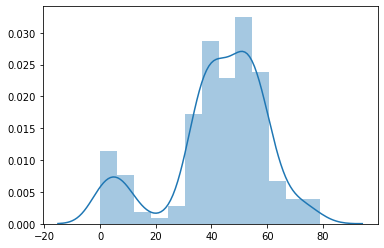

In [33]:
# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

sns.distplot(np.array(lstzero));

In [34]:
len(skip_countries)

149

From the distribution, 30 seems a reasonable cutoff (most countries still present)

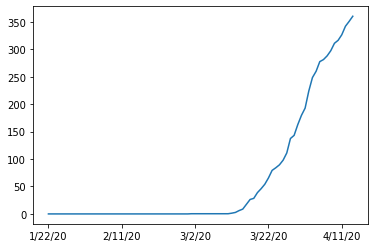

In [35]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [36]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.52296317e-01, 2.52296317e-01, 2.52296317e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.04858300e+01, 4.95951417e+01, 5.06072874e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.20342147e+00, 6.20342147e+00, 8.17723739e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        7.36435192e+02, 8.32579437e+02, 9.33083164e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.39667807e+03, 4.39667807e+03, 4.39667807e+03]])

In [37]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ..., -1.37715102,
        -1.37715102, -1.37715102],
       [       -inf,        -inf,        -inf, ...,  3.70095204,
         3.90389288,  3.92409559],
       [       -inf,        -inf,        -inf, ...,  1.82510099,
         1.82510099,  2.10135437],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  6.60182124,
         6.72452864,  6.83849433],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  8.38860455,
         8.38860455,  8.38860455]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [40]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days
case_train[3,5:8]

array([0., 0., 0.])

In [53]:
def clear_zero(nparray):
    # return the np array that contains only 1 0:
    lst = nparray.tolist()
    #print(len(lst))
    ind = 0
    splitInd = 0
    while(lst[ind]==0):
        splitInd += 1
        ind += 1
    #print(splitInd)
    return(np.array(lst[splitInd:]))

In [54]:
clear_zero(case_train[169,:]).shape[0]

74

In [55]:
t_days = 25 # number of days used to test 
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []


for i in range(len(countries)):
    print(countries[i] + " "+ str(i))
    
    if i in skip_countries:
        country_train_X.append(0)
        country_train_Y.append(0)

        country_valid_X.append(0)
        country_valid_Y.append(0)

        country_test_X.append(0)
        country_test_Y.append(0)
        continue # too little data 
        
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    newcase = clear_zero(case_train[i,:])
    total_days = newcase.shape[0]
    print(total_days)
    for j in range(total_days-pred_days*2-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(newcase[j:j+t_days])
        #print(str(j))
        out.append(newcase[j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(newcase[total_days-t_days-test_d*2:total_days-test_d*2])
    print(newcase[total_days-t_days-test_d*2:total_days-test_d*2].shape)
    country_valid_Y.append(newcase[total_days-test_d*2:total_days-test_d])
    print(newcase[total_days-test_d*2:total_days-test_d].shape)
    
    country_test_X.append(newcase[total_days-test_d-t_days:total_days-test_d])
    country_test_Y.append(newcase[total_days-test_d:])
    
    # the best way to check this
    #testlist = 


Burundi 0
Djibouti 1
Eritrea 2
Ethiopia 3
Kenya 4
Madagascar 5
Malawi 6
Mauritius 7
Mozambique 8
Rwanda 9
Seychelles 10
Somalia 11
South Sudan 12
Uganda 13
Tanzania 14
Zambia 15
Zimbabwe 16
Angola 17
Cameroon 18
Central African Republic 19
Chad 20
Equatorial Guinea 21
Gabon 22
Sao Tome and Principe 23
Botswana 24
Eswatini 25
Namibia 26
South Africa 27
Benin 28
Burkina Faso 29
Cabo Verde 30
Gambia 31
Ghana 32
Guinea 33
Guinea-Bissau 34
Liberia 35
Mali 36
Mauritania 37
Niger 38
Nigeria 39
Senegal 40
Sierra Leone 41
Togo 42
Algeria 43
Egypt 44
51
(25,)
(5,)
Libya 45
Morocco 46
Sudan 47
Tunisia 48
Western Sahara 49
Armenia 50
Azerbaijan 51
Bahrain 52
Cyprus 53
Georgia 54
Iraq 55
Israel 56
Jordan 57
Kuwait 58
Lebanon 59
Oman 60
Qatar 61
Saudi Arabia 62
Syria 63
Turkey 64
United Arab Emirates 65
67
(25,)
(5,)
Yemen 66
Kazakhstan 67
Kyrgyzstan 68
Uzbekistan 69
Afghanistan 70
Bangladesh 71
Bhutan 72
India 73
66
(25,)
(5,)
Iran 74
Maldives 75
Nepal 76
71
(25,)
(5,)
Pakistan 77
Sri Lanka 78
69
(

In [56]:
len(country_train_X)

172

In [57]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [59]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Discrete|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 5|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|

In [62]:
# Parameter
num_epochs = 50 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [63]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [64]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [65]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers,momentum):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers)+ "_"+ str(momentum) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) + "_"+ str(momentum)+".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.abs(torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel)
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs, labels) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs, y)
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = test_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [66]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss

In [70]:
#dimension check
a = torch.tensor(country_train_X[81]) #torch.Size([19, 30, 1, 1])
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# #torch.tensor(country_train_Y[0])
# torch.tensor(country_train_X[0])
# a.size(-1)
# torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# #torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

In [ ]:
# optimization grid
lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst = [10,30,50,100]
momentumS = [0.1,0.3,0.5,0.7,0.9]

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10
country_file_path = ("./country_file4.txt")
for i in range(len(countries)):
    if i in skip_countries:
        continue # too little data 
        
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./offline4/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    print(countries[i])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    country_file = open(country_file_path,"a")
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                for s in range(len(momentumS)):
                # train
                # specific parameters
                    learning_rate = lr_list[j]
                    hidden_dim = hState_lst[m]
                    num_layers = hidden_lst[k]
                    momentum = momentumS[s]

                    net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                    #print(net)
                    model = net.to(device)

                    #
                    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
                    # to be changed/optimized 

                    model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers,momentum)
                    print(err)
                    if err < best_error:
                        best_error = err
                        best_param = [lr_list[j],hidden_lst[k],hState_lst[m],momentum]
                        bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")
    
    print("%s, %s, %s, %s" % (countries[i], pred.tolist(), final_loss,best_param), file=country_file)
                   
    country_file.close()

Creating directory ./offline3/Egypt/training/
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0226
train error: 0.020525968007859774
0.022556299343705177
Saving the best model weights at Epoch [1], Best Valid Loss: 15.6656
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5210
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0212
train error: 0.030882886610925198
0.021189909428358078
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3801
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2874
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1064
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0481
Saving the best model w

Saving the best model weights at Epoch [11], Best Valid Loss: 6.0068
Saving the best model weights at Epoch [24], Best Valid Loss: 5.5557
Saving the best model weights at Epoch [36], Best Valid Loss: 5.4684
Saving the best model weights at Epoch [40], Best Valid Loss: 5.3827
train error: 2.3357565659098327
5.382728099822998
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9746
train error: 2.3385718999197707
2.9746220111846924
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9383
train error: 2.2644430216168985
2.9383111000061035
Saving the best model weights at Epoch [1], Best Valid Loss: 3.8957
train error: 2.4737530588172376
3.89567494392395
Saving the best model weights at Epoch [1], Best Valid Loss: 4.8281
train error: 2.2901840747799724
4.82808780670166
Saving the best model weights at Epoch [1], Best Valid Loss: 6.9794
Saving the best model weights at Epoch [6], Best Valid Loss: 6.2062
Saving the best model weights at Epoch [11], Best Valid Loss: 5.51

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0497
train error: 0.01877005078131333
0.049722861498594284
Saving the best model weights at Epoch [1], Best Valid Loss: 21.4651
Saving the best model weights at Epoch [2], Best Valid Loss: 10.6528
Saving the best model weights at Epoch [3], Best Valid Loss: 4.8413
Saving the best model weights at Epoch [4], Best Valid Loss: 2.9002
Saving the best model weights at Epoch [5], Best Valid Loss: 2.6560
Saving the best model weights at Epoch [6], Best Valid Loss: 1.5541
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2070
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1128
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0239
train error: 0.021937650904874317
0.023863522335886955
Saving the best model weights at Epoch [1], Best Valid Loss: 23.0659
Saving the best model weights at Epoch [2], Best Valid Loss: 12.8253
Saving the best model weights at Epoch [3], Best Valid Loss: 9.3801
Sa

Saving the best model weights at Epoch [8], Best Valid Loss: 8.1040
Saving the best model weights at Epoch [17], Best Valid Loss: 8.0640
Saving the best model weights at Epoch [38], Best Valid Loss: 7.9878
Saving the best model weights at Epoch [48], Best Valid Loss: 7.9080
train error: 2.029908935073763
7.907956123352051
Saving the best model weights at Epoch [1], Best Valid Loss: 22.7631
Saving the best model weights at Epoch [2], Best Valid Loss: 12.5464
Saving the best model weights at Epoch [3], Best Valid Loss: 7.6230
train error: 2.040135945077054
7.6229681968688965
Saving the best model weights at Epoch [1], Best Valid Loss: 22.1894
Saving the best model weights at Epoch [2], Best Valid Loss: 13.3130
Saving the best model weights at Epoch [3], Best Valid Loss: 7.8530
train error: 2.1171245996374637
7.853013038635254
Saving the best model weights at Epoch [1], Best Valid Loss: 22.1905
Saving the best model weights at Epoch [2], Best Valid Loss: 12.6343
Saving the best model weig

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1783
train error: 0.037950920610455796
0.17831145226955414
Saving the best model weights at Epoch [1], Best Valid Loss: 28.9924
Saving the best model weights at Epoch [2], Best Valid Loss: 24.9622
Saving the best model weights at Epoch [3], Best Valid Loss: 20.8655
Saving the best model weights at Epoch [4], Best Valid Loss: 15.9995
Saving the best model weights at Epoch [5], Best Valid Loss: 11.3883
Saving the best model weights at Epoch [6], Best Valid Loss: 7.1172
Saving the best model weights at Epoch [7], Best Valid Loss: 4.6466
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4917
Saving the best model weights at Epoch [9], Best Valid Loss: 1.4848
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0067
Saving the best model weights at Epoch [11], Best Valid Loss: 0.7840
Saving the best model weights at Epoch [12], Best Valid Loss: 0.7346
Saving the best model weights at Epoch [13], Best Val

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0481
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0452
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0360
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0330
train error: 0.03479758703906555
0.032972417771816254
Saving the best model weights at Epoch [1], Best Valid Loss: 29.4707
Saving the best model weights at Epoch [2], Best Valid Loss: 27.6320
Saving the best model weights at Epoch [3], Best Valid Loss: 25.9708
Saving the best model weights at Epoch [4], Best Valid Loss: 24.2353
Saving the best model weights at Epoch [5], Best Valid Loss: 22.8294
Saving the best model weights at Epoch [6], Best Valid Loss: 21.4665
Saving the best model weights at Epoch [7], Best Valid Loss: 20.1749
Saving the best model weights at Epoch [8], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 12.5267
Saving the best model weights at Epoch [15], Best Valid Loss: 11.5401
Saving the best model weights at Epoch [16], Best Valid Loss: 10.5891
Saving the best model weights at Epoch [17], Best Valid Loss: 9.7960
Saving the best model weights at Epoch [18], Best Valid Loss: 9.1136
Saving the best model weights at Epoch [19], Best Valid Loss: 8.2337
Saving the best model weights at Epoch [20], Best Valid Loss: 7.4927
Saving the best model weights at Epoch [21], Best Valid Loss: 7.0943
Saving the best model weights at Epoch [22], Best Valid Loss: 6.5945
Saving the best model weights at Epoch [23], Best Valid Loss: 6.1508
Saving the best model weights at Epoch [24], Best Valid Loss: 5.8666
Saving the best model weights at Epoch [25], Best Valid Loss: 5.3211
Saving the best model weights at Epoch [26], Best Valid Loss: 4.9741
Saving the best model weights at Epoch [27], Best Valid Loss: 4.6183
Saving the best model weights a

Saving the best model weights at Epoch [36], Best Valid Loss: 1.4975
Saving the best model weights at Epoch [37], Best Valid Loss: 1.3096
Saving the best model weights at Epoch [38], Best Valid Loss: 1.2024
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1559
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0496
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9038
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8975
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7713
Saving the best model weights at Epoch [44], Best Valid Loss: 0.6907
Saving the best model weights at Epoch [45], Best Valid Loss: 0.6335
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5858
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5069
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4769
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4091
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 11.4990
Saving the best model weights at Epoch [21], Best Valid Loss: 11.1077
Saving the best model weights at Epoch [22], Best Valid Loss: 10.8412
Saving the best model weights at Epoch [23], Best Valid Loss: 10.5740
Saving the best model weights at Epoch [24], Best Valid Loss: 10.2760
Saving the best model weights at Epoch [25], Best Valid Loss: 10.1193
Saving the best model weights at Epoch [26], Best Valid Loss: 9.8027
Saving the best model weights at Epoch [27], Best Valid Loss: 9.7676
Saving the best model weights at Epoch [28], Best Valid Loss: 9.6687
Saving the best model weights at Epoch [29], Best Valid Loss: 9.5291
Saving the best model weights at Epoch [30], Best Valid Loss: 9.3774
Saving the best model weights at Epoch [31], Best Valid Loss: 9.2633
Saving the best model weights at Epoch [32], Best Valid Loss: 9.1400
Saving the best model weights at Epoch [33], Best Valid Loss: 8.9489
Saving the best model weight

Saving the best model weights at Epoch [13], Best Valid Loss: 16.0117
Saving the best model weights at Epoch [14], Best Valid Loss: 15.3647
Saving the best model weights at Epoch [15], Best Valid Loss: 14.7495
Saving the best model weights at Epoch [16], Best Valid Loss: 14.1581
Saving the best model weights at Epoch [17], Best Valid Loss: 13.5295
Saving the best model weights at Epoch [18], Best Valid Loss: 13.1906
Saving the best model weights at Epoch [19], Best Valid Loss: 12.7275
Saving the best model weights at Epoch [20], Best Valid Loss: 12.3360
Saving the best model weights at Epoch [21], Best Valid Loss: 11.9206
Saving the best model weights at Epoch [22], Best Valid Loss: 11.5860
Saving the best model weights at Epoch [23], Best Valid Loss: 11.2730
Saving the best model weights at Epoch [24], Best Valid Loss: 11.0265
Saving the best model weights at Epoch [25], Best Valid Loss: 10.7870
Saving the best model weights at Epoch [26], Best Valid Loss: 10.7411
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 30.4353
Saving the best model weights at Epoch [2], Best Valid Loss: 28.6487
Saving the best model weights at Epoch [3], Best Valid Loss: 26.8643
Saving the best model weights at Epoch [4], Best Valid Loss: 25.2560
Saving the best model weights at Epoch [5], Best Valid Loss: 23.6174
Saving the best model weights at Epoch [6], Best Valid Loss: 22.4640
Saving the best model weights at Epoch [7], Best Valid Loss: 21.1972
Saving the best model weights at Epoch [8], Best Valid Loss: 20.0119
Saving the best model weights at Epoch [9], Best Valid Loss: 18.9342
Saving the best model weights at Epoch [10], Best Valid Loss: 17.9741
Saving the best model weights at Epoch [11], Best Valid Loss: 17.0211
Saving the best model weights at Epoch [12], Best Valid Loss: 16.2186
Saving the best model weights at Epoch [13], Best Valid Loss: 15.4970
Saving the best model weights at Epoch [14], Best Valid Loss: 14.8408
Saving the best model weights

Saving the best model weights at Epoch [31], Best Valid Loss: 9.8583
Saving the best model weights at Epoch [32], Best Valid Loss: 9.7691
Saving the best model weights at Epoch [33], Best Valid Loss: 9.6009
Saving the best model weights at Epoch [34], Best Valid Loss: 9.4152
Saving the best model weights at Epoch [36], Best Valid Loss: 9.3351
Saving the best model weights at Epoch [37], Best Valid Loss: 9.2769
Saving the best model weights at Epoch [38], Best Valid Loss: 9.2420
Saving the best model weights at Epoch [39], Best Valid Loss: 9.2300
Saving the best model weights at Epoch [40], Best Valid Loss: 9.1846
Saving the best model weights at Epoch [41], Best Valid Loss: 9.0420
Saving the best model weights at Epoch [42], Best Valid Loss: 9.0103
Saving the best model weights at Epoch [45], Best Valid Loss: 8.9428
Saving the best model weights at Epoch [46], Best Valid Loss: 8.9306
Saving the best model weights at Epoch [47], Best Valid Loss: 8.8983
Saving the best model weights at E

Saving the best model weights at Epoch [17], Best Valid Loss: 13.1372
Saving the best model weights at Epoch [18], Best Valid Loss: 12.6794
Saving the best model weights at Epoch [19], Best Valid Loss: 12.1906
Saving the best model weights at Epoch [20], Best Valid Loss: 11.8614
Saving the best model weights at Epoch [21], Best Valid Loss: 11.4272
Saving the best model weights at Epoch [22], Best Valid Loss: 11.0704
Saving the best model weights at Epoch [23], Best Valid Loss: 10.9274
Saving the best model weights at Epoch [24], Best Valid Loss: 10.6668
Saving the best model weights at Epoch [25], Best Valid Loss: 10.4781
Saving the best model weights at Epoch [26], Best Valid Loss: 10.2495
Saving the best model weights at Epoch [27], Best Valid Loss: 10.0464
Saving the best model weights at Epoch [28], Best Valid Loss: 9.8105
Saving the best model weights at Epoch [29], Best Valid Loss: 9.7736
Saving the best model weights at Epoch [30], Best Valid Loss: 9.6516
Saving the best model w

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0408
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0238
train error: 0.02208071414497681
0.023813186213374138
Saving the best model weights at Epoch [1], Best Valid Loss: 17.7770
Saving the best model weights at Epoch [2], Best Valid Loss: 0.7809
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0947
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0849
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0663
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0178
train error: 0.02326503102085553
0.01784958504140377
Saving the best model weights at Epoch [1], Best Valid Loss: 25.7882
Saving the best model weights at Epoch [2], Best Valid Loss: 19.0689
Sa

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3734
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1309
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0919
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0371
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0342
train error: 0.030906355816114228
0.034150220453739166
Saving the best model weights at Epoch [1], Best Valid Loss: 26.7882
Saving the best model weights at Epoch [2], Best Valid Loss: 19.9222
Saving the best model weights at Epoch [3], Best Valid Loss: 15.3087
Saving the best model weights at Epoch [4], Best Valid Loss: 13.0671
Saving the best model weights at Epoch [5], Best Valid Loss: 10.6856
Saving the best model weights at Epoch [6], Best Valid Loss: 9.5763
Saving the best model weights at Epoch [7], Best 

Saving the best model weights at Epoch [5], Best Valid Loss: 9.5973
Saving the best model weights at Epoch [6], Best Valid Loss: 9.0519
Saving the best model weights at Epoch [7], Best Valid Loss: 8.2854
Saving the best model weights at Epoch [14], Best Valid Loss: 8.2186
Saving the best model weights at Epoch [15], Best Valid Loss: 8.2042
Saving the best model weights at Epoch [18], Best Valid Loss: 7.7557
Saving the best model weights at Epoch [19], Best Valid Loss: 7.6632
Saving the best model weights at Epoch [20], Best Valid Loss: 7.3974
Saving the best model weights at Epoch [21], Best Valid Loss: 7.3769
Saving the best model weights at Epoch [22], Best Valid Loss: 6.8037
Saving the best model weights at Epoch [24], Best Valid Loss: 6.0400
Saving the best model weights at Epoch [25], Best Valid Loss: 5.4458
Saving the best model weights at Epoch [26], Best Valid Loss: 5.0619
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2407
Saving the best model weights at Epoc

Saving the best model weights at Epoch [4], Best Valid Loss: 11.7948
Saving the best model weights at Epoch [5], Best Valid Loss: 10.3477
Saving the best model weights at Epoch [6], Best Valid Loss: 9.8474
Saving the best model weights at Epoch [7], Best Valid Loss: 8.8604
Saving the best model weights at Epoch [8], Best Valid Loss: 8.5767
Saving the best model weights at Epoch [10], Best Valid Loss: 8.4904
Saving the best model weights at Epoch [12], Best Valid Loss: 8.4406
Saving the best model weights at Epoch [13], Best Valid Loss: 8.1410
train error: 2.066817393177189
8.141029357910156
Saving the best model weights at Epoch [1], Best Valid Loss: 26.3236
Saving the best model weights at Epoch [2], Best Valid Loss: 19.8061
Saving the best model weights at Epoch [3], Best Valid Loss: 14.9663
Saving the best model weights at Epoch [4], Best Valid Loss: 11.4009
Saving the best model weights at Epoch [5], Best Valid Loss: 10.1317
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [4], Best Valid Loss: 29.9486
Saving the best model weights at Epoch [5], Best Valid Loss: 29.5126
Saving the best model weights at Epoch [6], Best Valid Loss: 29.0740
Saving the best model weights at Epoch [7], Best Valid Loss: 28.6284
Saving the best model weights at Epoch [8], Best Valid Loss: 28.1659
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7148
Saving the best model weights at Epoch [10], Best Valid Loss: 27.2359
Saving the best model weights at Epoch [11], Best Valid Loss: 26.7820
Saving the best model weights at Epoch [12], Best Valid Loss: 26.3361
Saving the best model weights at Epoch [13], Best Valid Loss: 25.8532
Saving the best model weights at Epoch [14], Best Valid Loss: 25.4263
Saving the best model weights at Epoch [15], Best Valid Loss: 24.9428
Saving the best model weights at Epoch [16], Best Valid Loss: 24.4807
Saving the best model weights at Epoch [17], Best Valid Loss: 24.0182
Saving the best model weig

Saving the best model weights at Epoch [24], Best Valid Loss: 18.5539
Saving the best model weights at Epoch [25], Best Valid Loss: 17.8807
Saving the best model weights at Epoch [26], Best Valid Loss: 17.2851
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6634
Saving the best model weights at Epoch [28], Best Valid Loss: 15.9610
Saving the best model weights at Epoch [29], Best Valid Loss: 15.3598
Saving the best model weights at Epoch [30], Best Valid Loss: 14.7507
Saving the best model weights at Epoch [31], Best Valid Loss: 14.0755
Saving the best model weights at Epoch [32], Best Valid Loss: 13.5530
Saving the best model weights at Epoch [33], Best Valid Loss: 12.9437
Saving the best model weights at Epoch [34], Best Valid Loss: 12.2921
Saving the best model weights at Epoch [35], Best Valid Loss: 11.6987
Saving the best model weights at Epoch [36], Best Valid Loss: 11.0813
Saving the best model weights at Epoch [37], Best Valid Loss: 10.5537
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 23.9900
Saving the best model weights at Epoch [46], Best Valid Loss: 23.8234
Saving the best model weights at Epoch [47], Best Valid Loss: 23.6733
Saving the best model weights at Epoch [48], Best Valid Loss: 23.5188
Saving the best model weights at Epoch [49], Best Valid Loss: 23.3509
Saving the best model weights at Epoch [50], Best Valid Loss: 23.2072
train error: 5.590352800121764
23.2071590423584
Saving the best model weights at Epoch [1], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [2], Best Valid Loss: 31.3728
Saving the best model weights at Epoch [3], Best Valid Loss: 31.1539
Saving the best model weights at Epoch [4], Best Valid Loss: 30.9351
Saving the best model weights at Epoch [5], Best Valid Loss: 30.7296
Saving the best model weights at Epoch [6], Best Valid Loss: 30.5173
Saving the best model weights at Epoch [7], Best Valid Loss: 30.3032
Saving the best model weights at Epoch [8], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 28.9045
Saving the best model weights at Epoch [15], Best Valid Loss: 28.7156
Saving the best model weights at Epoch [16], Best Valid Loss: 28.5104
Saving the best model weights at Epoch [17], Best Valid Loss: 28.3086
Saving the best model weights at Epoch [18], Best Valid Loss: 28.1160
Saving the best model weights at Epoch [19], Best Valid Loss: 27.9255
Saving the best model weights at Epoch [20], Best Valid Loss: 27.7444
Saving the best model weights at Epoch [21], Best Valid Loss: 27.5577
Saving the best model weights at Epoch [22], Best Valid Loss: 27.3846
Saving the best model weights at Epoch [23], Best Valid Loss: 27.1940
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0240
Saving the best model weights at Epoch [25], Best Valid Loss: 26.8418
Saving the best model weights at Epoch [26], Best Valid Loss: 26.6662
Saving the best model weights at Epoch [27], Best Valid Loss: 26.4847
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 26.2671
Saving the best model weights at Epoch [31], Best Valid Loss: 26.1215
Saving the best model weights at Epoch [32], Best Valid Loss: 25.9616
Saving the best model weights at Epoch [33], Best Valid Loss: 25.8059
Saving the best model weights at Epoch [34], Best Valid Loss: 25.6505
Saving the best model weights at Epoch [35], Best Valid Loss: 25.5081
Saving the best model weights at Epoch [36], Best Valid Loss: 25.3545
Saving the best model weights at Epoch [37], Best Valid Loss: 25.2012
Saving the best model weights at Epoch [38], Best Valid Loss: 25.0684
Saving the best model weights at Epoch [39], Best Valid Loss: 24.9202
Saving the best model weights at Epoch [40], Best Valid Loss: 24.7730
Saving the best model weights at Epoch [41], Best Valid Loss: 24.6282
Saving the best model weights at Epoch [42], Best Valid Loss: 24.4968
Saving the best model weights at Epoch [43], Best Valid Loss: 24.3459
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 23.9348
Saving the best model weights at Epoch [47], Best Valid Loss: 23.7866
Saving the best model weights at Epoch [48], Best Valid Loss: 23.6579
Saving the best model weights at Epoch [49], Best Valid Loss: 23.5124
Saving the best model weights at Epoch [50], Best Valid Loss: 23.3759
train error: 5.597608094860334
23.375885009765625
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4690
Saving the best model weights at Epoch [2], Best Valid Loss: 31.2768
Saving the best model weights at Epoch [3], Best Valid Loss: 31.0645
Saving the best model weights at Epoch [4], Best Valid Loss: 30.8689
Saving the best model weights at Epoch [5], Best Valid Loss: 30.6759
Saving the best model weights at Epoch [6], Best Valid Loss: 30.4782
Saving the best model weights at Epoch [7], Best Valid Loss: 30.2784
Saving the best model weights at Epoch [8], Best Valid Loss: 30.0750
Saving the best model weights at Epoch [9], Best

Saving the best model weights at Epoch [14], Best Valid Loss: 28.8132
Saving the best model weights at Epoch [15], Best Valid Loss: 28.6212
Saving the best model weights at Epoch [16], Best Valid Loss: 28.4559
Saving the best model weights at Epoch [17], Best Valid Loss: 28.2794
Saving the best model weights at Epoch [18], Best Valid Loss: 28.1016
Saving the best model weights at Epoch [19], Best Valid Loss: 27.9321
Saving the best model weights at Epoch [20], Best Valid Loss: 27.7587
Saving the best model weights at Epoch [21], Best Valid Loss: 27.5895
Saving the best model weights at Epoch [22], Best Valid Loss: 27.4154
Saving the best model weights at Epoch [23], Best Valid Loss: 27.2373
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0671
Saving the best model weights at Epoch [25], Best Valid Loss: 26.9187
Saving the best model weights at Epoch [26], Best Valid Loss: 26.7499
Saving the best model weights at Epoch [27], Best Valid Loss: 26.5794
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 26.5996
Saving the best model weights at Epoch [32], Best Valid Loss: 26.4402
Saving the best model weights at Epoch [33], Best Valid Loss: 26.2874
Saving the best model weights at Epoch [34], Best Valid Loss: 26.1180
Saving the best model weights at Epoch [35], Best Valid Loss: 25.9711
Saving the best model weights at Epoch [36], Best Valid Loss: 25.8147
Saving the best model weights at Epoch [37], Best Valid Loss: 25.6568
Saving the best model weights at Epoch [38], Best Valid Loss: 25.5232
Saving the best model weights at Epoch [39], Best Valid Loss: 25.3576
Saving the best model weights at Epoch [40], Best Valid Loss: 25.2193
Saving the best model weights at Epoch [41], Best Valid Loss: 25.0711
Saving the best model weights at Epoch [42], Best Valid Loss: 24.9277
Saving the best model weights at Epoch [43], Best Valid Loss: 24.7674
Saving the best model weights at Epoch [44], Best Valid Loss: 24.6377
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 23.5538
Saving the best model weights at Epoch [48], Best Valid Loss: 23.4263
Saving the best model weights at Epoch [49], Best Valid Loss: 23.2853
Saving the best model weights at Epoch [50], Best Valid Loss: 23.1617
train error: 5.505411398538854
23.161684036254883
Saving the best model weights at Epoch [1], Best Valid Loss: 31.0202
Saving the best model weights at Epoch [2], Best Valid Loss: 30.8228
Saving the best model weights at Epoch [3], Best Valid Loss: 30.6326
Saving the best model weights at Epoch [4], Best Valid Loss: 30.4247
Saving the best model weights at Epoch [5], Best Valid Loss: 30.2368
Saving the best model weights at Epoch [6], Best Valid Loss: 30.0385
Saving the best model weights at Epoch [7], Best Valid Loss: 29.8365
Saving the best model weights at Epoch [8], Best Valid Loss: 29.6449
Saving the best model weights at Epoch [9], Best Valid Loss: 29.4701
Saving the best model weights at Epoch [10], Best

Saving the best model weights at Epoch [16], Best Valid Loss: 28.6201
Saving the best model weights at Epoch [17], Best Valid Loss: 28.4437
Saving the best model weights at Epoch [18], Best Valid Loss: 28.2765
Saving the best model weights at Epoch [19], Best Valid Loss: 28.1002
Saving the best model weights at Epoch [20], Best Valid Loss: 27.9325
Saving the best model weights at Epoch [21], Best Valid Loss: 27.7491
Saving the best model weights at Epoch [22], Best Valid Loss: 27.5837
Saving the best model weights at Epoch [23], Best Valid Loss: 27.4096
Saving the best model weights at Epoch [24], Best Valid Loss: 27.2508
Saving the best model weights at Epoch [25], Best Valid Loss: 27.0900
Saving the best model weights at Epoch [26], Best Valid Loss: 26.9156
Saving the best model weights at Epoch [27], Best Valid Loss: 26.7649
Saving the best model weights at Epoch [28], Best Valid Loss: 26.5986
Saving the best model weights at Epoch [29], Best Valid Loss: 26.4369
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 1.0232
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9857
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9600
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9453
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8989
Saving the best model weights at Epoch [46], Best Valid Loss: 0.8509
Saving the best model weights at Epoch [47], Best Valid Loss: 0.8323
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8005
Saving the best model weights at Epoch [49], Best Valid Loss: 0.7939
Saving the best model weights at Epoch [50], Best Valid Loss: 0.7604
train error: 0.07633917736529838
0.760407567024231
Saving the best model weights at Epoch [1], Best Valid Loss: 30.2578
Saving the best model weights at Epoch [2], Best Valid Loss: 28.5252
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [11], Best Valid Loss: 5.9092
Saving the best model weights at Epoch [12], Best Valid Loss: 4.2055
Saving the best model weights at Epoch [13], Best Valid Loss: 3.1606
Saving the best model weights at Epoch [14], Best Valid Loss: 2.1050
Saving the best model weights at Epoch [15], Best Valid Loss: 1.5597
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1657
Saving the best model weights at Epoch [17], Best Valid Loss: 0.8557
Saving the best model weights at Epoch [18], Best Valid Loss: 0.6717
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5357
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4656
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3974
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3583
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3305
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3107
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 7.6753
Saving the best model weights at Epoch [43], Best Valid Loss: 7.4822
Saving the best model weights at Epoch [44], Best Valid Loss: 7.1831
Saving the best model weights at Epoch [45], Best Valid Loss: 7.0716
Saving the best model weights at Epoch [46], Best Valid Loss: 6.7581
Saving the best model weights at Epoch [47], Best Valid Loss: 6.5710
Saving the best model weights at Epoch [48], Best Valid Loss: 6.4652
Saving the best model weights at Epoch [49], Best Valid Loss: 6.2754
Saving the best model weights at Epoch [50], Best Valid Loss: 6.1174
train error: 1.270620752708055
6.117380619049072
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4796
Saving the best model weights at Epoch [2], Best Valid Loss: 30.4409
Saving the best model weights at Epoch [3], Best Valid Loss: 29.4642
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5073
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 23.0936
Saving the best model weights at Epoch [11], Best Valid Loss: 22.3600
Saving the best model weights at Epoch [12], Best Valid Loss: 21.6158
Saving the best model weights at Epoch [13], Best Valid Loss: 20.8032
Saving the best model weights at Epoch [14], Best Valid Loss: 20.1190
Saving the best model weights at Epoch [15], Best Valid Loss: 19.4444
Saving the best model weights at Epoch [16], Best Valid Loss: 18.8090
Saving the best model weights at Epoch [17], Best Valid Loss: 18.1145
Saving the best model weights at Epoch [18], Best Valid Loss: 17.5100
Saving the best model weights at Epoch [19], Best Valid Loss: 16.8138
Saving the best model weights at Epoch [20], Best Valid Loss: 16.2365
Saving the best model weights at Epoch [21], Best Valid Loss: 15.6149
Saving the best model weights at Epoch [22], Best Valid Loss: 14.9784
Saving the best model weights at Epoch [23], Best Valid Loss: 14.3779
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 14.4473
Saving the best model weights at Epoch [31], Best Valid Loss: 14.1406
Saving the best model weights at Epoch [32], Best Valid Loss: 13.8854
Saving the best model weights at Epoch [33], Best Valid Loss: 13.5755
Saving the best model weights at Epoch [34], Best Valid Loss: 13.3853
Saving the best model weights at Epoch [35], Best Valid Loss: 13.1249
Saving the best model weights at Epoch [36], Best Valid Loss: 12.9092
Saving the best model weights at Epoch [37], Best Valid Loss: 12.6833
Saving the best model weights at Epoch [38], Best Valid Loss: 12.5315
Saving the best model weights at Epoch [39], Best Valid Loss: 12.2931
Saving the best model weights at Epoch [40], Best Valid Loss: 12.1592
Saving the best model weights at Epoch [41], Best Valid Loss: 11.9595
Saving the best model weights at Epoch [42], Best Valid Loss: 11.8111
Saving the best model weights at Epoch [43], Best Valid Loss: 11.6107
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 10.2830
train error: 2.0632037423783913
10.282980918884277
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4501
Saving the best model weights at Epoch [2], Best Valid Loss: 30.4647
Saving the best model weights at Epoch [3], Best Valid Loss: 29.5052
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5487
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6708
Saving the best model weights at Epoch [6], Best Valid Loss: 26.8506
Saving the best model weights at Epoch [7], Best Valid Loss: 25.9584
Saving the best model weights at Epoch [8], Best Valid Loss: 25.2028
Saving the best model weights at Epoch [9], Best Valid Loss: 24.4451
Saving the best model weights at Epoch [10], Best Valid Loss: 23.8009
Saving the best model weights at Epoch [11], Best Valid Loss: 23.0960
Saving the best model weights at Epoch [12], Best Valid Loss: 22.4093
Saving the best model weights at Epoch [13], Bes

Saving the best model weights at Epoch [18], Best Valid Loss: 18.5007
Saving the best model weights at Epoch [19], Best Valid Loss: 17.9756
Saving the best model weights at Epoch [20], Best Valid Loss: 17.4852
Saving the best model weights at Epoch [21], Best Valid Loss: 17.0738
Saving the best model weights at Epoch [22], Best Valid Loss: 16.6085
Saving the best model weights at Epoch [23], Best Valid Loss: 16.2502
Saving the best model weights at Epoch [24], Best Valid Loss: 15.8479
Saving the best model weights at Epoch [25], Best Valid Loss: 15.5012
Saving the best model weights at Epoch [26], Best Valid Loss: 15.1140
Saving the best model weights at Epoch [27], Best Valid Loss: 14.8765
Saving the best model weights at Epoch [28], Best Valid Loss: 14.5322
Saving the best model weights at Epoch [29], Best Valid Loss: 14.2576
Saving the best model weights at Epoch [30], Best Valid Loss: 13.8936
Saving the best model weights at Epoch [31], Best Valid Loss: 13.6408
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 12.8125
Saving the best model weights at Epoch [36], Best Valid Loss: 12.5682
Saving the best model weights at Epoch [37], Best Valid Loss: 12.3722
Saving the best model weights at Epoch [38], Best Valid Loss: 12.1069
Saving the best model weights at Epoch [39], Best Valid Loss: 11.9861
Saving the best model weights at Epoch [40], Best Valid Loss: 11.8141
Saving the best model weights at Epoch [41], Best Valid Loss: 11.7173
Saving the best model weights at Epoch [42], Best Valid Loss: 11.5044
Saving the best model weights at Epoch [43], Best Valid Loss: 11.3679
Saving the best model weights at Epoch [44], Best Valid Loss: 11.2154
Saving the best model weights at Epoch [45], Best Valid Loss: 11.0105
Saving the best model weights at Epoch [46], Best Valid Loss: 10.9090
Saving the best model weights at Epoch [47], Best Valid Loss: 10.7841
Saving the best model weights at Epoch [48], Best Valid Loss: 10.6137
Saving the best mode

Saving the best model weights at Epoch [3], Best Valid Loss: 29.4906
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5781
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6873
Saving the best model weights at Epoch [6], Best Valid Loss: 26.8193
Saving the best model weights at Epoch [7], Best Valid Loss: 26.0366
Saving the best model weights at Epoch [8], Best Valid Loss: 25.2664
Saving the best model weights at Epoch [9], Best Valid Loss: 24.5176
Saving the best model weights at Epoch [10], Best Valid Loss: 23.8077
Saving the best model weights at Epoch [11], Best Valid Loss: 23.2561
Saving the best model weights at Epoch [12], Best Valid Loss: 22.5669
Saving the best model weights at Epoch [13], Best Valid Loss: 21.9210
Saving the best model weights at Epoch [14], Best Valid Loss: 21.3637
Saving the best model weights at Epoch [15], Best Valid Loss: 20.7505
Saving the best model weights at Epoch [16], Best Valid Loss: 20.1982
Saving the best model weigh

Saving the best model weights at Epoch [19], Best Valid Loss: 18.5696
Saving the best model weights at Epoch [20], Best Valid Loss: 18.1484
Saving the best model weights at Epoch [21], Best Valid Loss: 17.6750
Saving the best model weights at Epoch [22], Best Valid Loss: 17.2544
Saving the best model weights at Epoch [23], Best Valid Loss: 16.8257
Saving the best model weights at Epoch [24], Best Valid Loss: 16.3933
Saving the best model weights at Epoch [25], Best Valid Loss: 15.9244
Saving the best model weights at Epoch [26], Best Valid Loss: 15.6298
Saving the best model weights at Epoch [27], Best Valid Loss: 15.2569
Saving the best model weights at Epoch [28], Best Valid Loss: 14.8845
Saving the best model weights at Epoch [29], Best Valid Loss: 14.6064
Saving the best model weights at Epoch [30], Best Valid Loss: 14.2646
Saving the best model weights at Epoch [31], Best Valid Loss: 14.0175
Saving the best model weights at Epoch [32], Best Valid Loss: 13.7372
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 12.9898
Saving the best model weights at Epoch [36], Best Valid Loss: 12.7579
Saving the best model weights at Epoch [37], Best Valid Loss: 12.5246
Saving the best model weights at Epoch [38], Best Valid Loss: 12.3713
Saving the best model weights at Epoch [39], Best Valid Loss: 12.1511
Saving the best model weights at Epoch [40], Best Valid Loss: 11.9765
Saving the best model weights at Epoch [41], Best Valid Loss: 11.7694
Saving the best model weights at Epoch [42], Best Valid Loss: 11.5824
Saving the best model weights at Epoch [43], Best Valid Loss: 11.4173
Saving the best model weights at Epoch [44], Best Valid Loss: 11.2696
Saving the best model weights at Epoch [45], Best Valid Loss: 11.2011
Saving the best model weights at Epoch [46], Best Valid Loss: 11.0105
Saving the best model weights at Epoch [47], Best Valid Loss: 10.8555
Saving the best model weights at Epoch [48], Best Valid Loss: 10.6941
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 31.1041
Saving the best model weights at Epoch [5], Best Valid Loss: 31.0549
Saving the best model weights at Epoch [6], Best Valid Loss: 31.0019
Saving the best model weights at Epoch [7], Best Valid Loss: 30.9526
Saving the best model weights at Epoch [8], Best Valid Loss: 30.9018
Saving the best model weights at Epoch [9], Best Valid Loss: 30.8546
Saving the best model weights at Epoch [10], Best Valid Loss: 30.8037
Saving the best model weights at Epoch [11], Best Valid Loss: 30.7526
Saving the best model weights at Epoch [12], Best Valid Loss: 30.7067
Saving the best model weights at Epoch [13], Best Valid Loss: 30.6583
Saving the best model weights at Epoch [14], Best Valid Loss: 30.6026
Saving the best model weights at Epoch [15], Best Valid Loss: 30.5531
Saving the best model weights at Epoch [16], Best Valid Loss: 30.5059
Saving the best model weights at Epoch [17], Best Valid Loss: 30.4548
Saving the best model weig

Saving the best model weights at Epoch [21], Best Valid Loss: 30.6998
Saving the best model weights at Epoch [22], Best Valid Loss: 30.6429
Saving the best model weights at Epoch [23], Best Valid Loss: 30.5843
Saving the best model weights at Epoch [24], Best Valid Loss: 30.5297
Saving the best model weights at Epoch [25], Best Valid Loss: 30.4793
Saving the best model weights at Epoch [26], Best Valid Loss: 30.4274
Saving the best model weights at Epoch [27], Best Valid Loss: 30.3728
Saving the best model weights at Epoch [28], Best Valid Loss: 30.3151
Saving the best model weights at Epoch [29], Best Valid Loss: 30.2603
Saving the best model weights at Epoch [30], Best Valid Loss: 30.2111
Saving the best model weights at Epoch [31], Best Valid Loss: 30.1568
Saving the best model weights at Epoch [32], Best Valid Loss: 30.1036
Saving the best model weights at Epoch [33], Best Valid Loss: 30.0497
Saving the best model weights at Epoch [34], Best Valid Loss: 29.9947
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 30.9177
Saving the best model weights at Epoch [41], Best Valid Loss: 30.8965
Saving the best model weights at Epoch [42], Best Valid Loss: 30.8743
Saving the best model weights at Epoch [43], Best Valid Loss: 30.8545
Saving the best model weights at Epoch [44], Best Valid Loss: 30.8346
Saving the best model weights at Epoch [45], Best Valid Loss: 30.8144
Saving the best model weights at Epoch [46], Best Valid Loss: 30.7930
Saving the best model weights at Epoch [47], Best Valid Loss: 30.7716
Saving the best model weights at Epoch [48], Best Valid Loss: 30.7510
Saving the best model weights at Epoch [49], Best Valid Loss: 30.7310
Saving the best model weights at Epoch [50], Best Valid Loss: 30.7108
train error: 8.767980327829719
30.71082878112793
Saving the best model weights at Epoch [1], Best Valid Loss: 32.1721
Saving the best model weights at Epoch [2], Best Valid Loss: 32.1507
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [10], Best Valid Loss: 31.3583
Saving the best model weights at Epoch [11], Best Valid Loss: 31.3380
Saving the best model weights at Epoch [12], Best Valid Loss: 31.3169
Saving the best model weights at Epoch [13], Best Valid Loss: 31.2938
Saving the best model weights at Epoch [14], Best Valid Loss: 31.2732
Saving the best model weights at Epoch [15], Best Valid Loss: 31.2512
Saving the best model weights at Epoch [16], Best Valid Loss: 31.2296
Saving the best model weights at Epoch [17], Best Valid Loss: 31.2080
Saving the best model weights at Epoch [18], Best Valid Loss: 31.1865
Saving the best model weights at Epoch [19], Best Valid Loss: 31.1640
Saving the best model weights at Epoch [20], Best Valid Loss: 31.1440
Saving the best model weights at Epoch [21], Best Valid Loss: 31.1211
Saving the best model weights at Epoch [22], Best Valid Loss: 31.0989
Saving the best model weights at Epoch [23], Best Valid Loss: 31.0786
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 31.0211
Saving the best model weights at Epoch [31], Best Valid Loss: 31.0001
Saving the best model weights at Epoch [32], Best Valid Loss: 30.9804
Saving the best model weights at Epoch [33], Best Valid Loss: 30.9601
Saving the best model weights at Epoch [34], Best Valid Loss: 30.9389
Saving the best model weights at Epoch [35], Best Valid Loss: 30.9204
Saving the best model weights at Epoch [36], Best Valid Loss: 30.9009
Saving the best model weights at Epoch [37], Best Valid Loss: 30.8793
Saving the best model weights at Epoch [38], Best Valid Loss: 30.8599
Saving the best model weights at Epoch [39], Best Valid Loss: 30.8403
Saving the best model weights at Epoch [40], Best Valid Loss: 30.8195
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7984
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7787
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7588
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 30.9107
train error: 8.841907400637865
30.91072654724121
Saving the best model weights at Epoch [1], Best Valid Loss: 31.7442
Saving the best model weights at Epoch [2], Best Valid Loss: 31.7239
Saving the best model weights at Epoch [3], Best Valid Loss: 31.7037
Saving the best model weights at Epoch [4], Best Valid Loss: 31.6835
Saving the best model weights at Epoch [5], Best Valid Loss: 31.6614
Saving the best model weights at Epoch [6], Best Valid Loss: 31.6411
Saving the best model weights at Epoch [7], Best Valid Loss: 31.6204
Saving the best model weights at Epoch [8], Best Valid Loss: 31.5989
Saving the best model weights at Epoch [9], Best Valid Loss: 31.5793
Saving the best model weights at Epoch [10], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [11], Best Valid Loss: 31.5377
Saving the best model weights at Epoch [12], Best Valid Loss: 31.5169
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [18], Best Valid Loss: 31.1980
Saving the best model weights at Epoch [19], Best Valid Loss: 31.1774
Saving the best model weights at Epoch [20], Best Valid Loss: 31.1565
Saving the best model weights at Epoch [21], Best Valid Loss: 31.1355
Saving the best model weights at Epoch [22], Best Valid Loss: 31.1151
Saving the best model weights at Epoch [23], Best Valid Loss: 31.0939
Saving the best model weights at Epoch [24], Best Valid Loss: 31.0723
Saving the best model weights at Epoch [25], Best Valid Loss: 31.0519
Saving the best model weights at Epoch [26], Best Valid Loss: 31.0305
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0094
Saving the best model weights at Epoch [28], Best Valid Loss: 30.9899
Saving the best model weights at Epoch [29], Best Valid Loss: 30.9680
Saving the best model weights at Epoch [30], Best Valid Loss: 30.9476
Saving the best model weights at Epoch [31], Best Valid Loss: 30.9266
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 30.8609
Saving the best model weights at Epoch [36], Best Valid Loss: 30.8399
Saving the best model weights at Epoch [37], Best Valid Loss: 30.8208
Saving the best model weights at Epoch [38], Best Valid Loss: 30.8014
Saving the best model weights at Epoch [39], Best Valid Loss: 30.7817
Saving the best model weights at Epoch [40], Best Valid Loss: 30.7603
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7405
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7210
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7000
Saving the best model weights at Epoch [44], Best Valid Loss: 30.6817
Saving the best model weights at Epoch [45], Best Valid Loss: 30.6601
Saving the best model weights at Epoch [46], Best Valid Loss: 30.6414
Saving the best model weights at Epoch [47], Best Valid Loss: 30.6220
Saving the best model weights at Epoch [48], Best Valid Loss: 30.6017
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 31.0920
Saving the best model weights at Epoch [5], Best Valid Loss: 31.0721
Saving the best model weights at Epoch [6], Best Valid Loss: 31.0519
Saving the best model weights at Epoch [7], Best Valid Loss: 31.0315
Saving the best model weights at Epoch [8], Best Valid Loss: 31.0100
Saving the best model weights at Epoch [9], Best Valid Loss: 30.9897
Saving the best model weights at Epoch [10], Best Valid Loss: 30.9698
Saving the best model weights at Epoch [11], Best Valid Loss: 30.9501
Saving the best model weights at Epoch [12], Best Valid Loss: 30.9298
Saving the best model weights at Epoch [13], Best Valid Loss: 30.9103
Saving the best model weights at Epoch [14], Best Valid Loss: 30.8893
Saving the best model weights at Epoch [15], Best Valid Loss: 30.8686
Saving the best model weights at Epoch [16], Best Valid Loss: 30.8482
Saving the best model weights at Epoch [17], Best Valid Loss: 30.8292
Saving the best model weig

Saving the best model weights at Epoch [23], Best Valid Loss: 31.1454
Saving the best model weights at Epoch [24], Best Valid Loss: 31.1249
Saving the best model weights at Epoch [25], Best Valid Loss: 31.1039
Saving the best model weights at Epoch [26], Best Valid Loss: 31.0829
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0639
Saving the best model weights at Epoch [28], Best Valid Loss: 31.0430
Saving the best model weights at Epoch [29], Best Valid Loss: 31.0233
Saving the best model weights at Epoch [30], Best Valid Loss: 31.0024
Saving the best model weights at Epoch [31], Best Valid Loss: 30.9832
Saving the best model weights at Epoch [32], Best Valid Loss: 30.9636
Saving the best model weights at Epoch [33], Best Valid Loss: 30.9429
Saving the best model weights at Epoch [34], Best Valid Loss: 30.9228
Saving the best model weights at Epoch [35], Best Valid Loss: 30.9013
Saving the best model weights at Epoch [36], Best Valid Loss: 30.8828
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 33.2113
Saving the best model weights at Epoch [47], Best Valid Loss: 33.2069
Saving the best model weights at Epoch [48], Best Valid Loss: 33.2027
Saving the best model weights at Epoch [49], Best Valid Loss: 33.1981
Saving the best model weights at Epoch [50], Best Valid Loss: 33.1939
train error: 9.723992459475994
33.19392013549805
Saving the best model weights at Epoch [1], Best Valid Loss: 30.6922
Saving the best model weights at Epoch [2], Best Valid Loss: 30.6883
Saving the best model weights at Epoch [3], Best Valid Loss: 30.6845
Saving the best model weights at Epoch [4], Best Valid Loss: 30.6803
Saving the best model weights at Epoch [5], Best Valid Loss: 30.6763
Saving the best model weights at Epoch [6], Best Valid Loss: 30.6720
Saving the best model weights at Epoch [7], Best Valid Loss: 30.6680
Saving the best model weights at Epoch [8], Best Valid Loss: 30.6636
Saving the best model weights at Epoch [9], Best 

Saving the best model weights at Epoch [13], Best Valid Loss: 31.8465
Saving the best model weights at Epoch [14], Best Valid Loss: 31.8412
Saving the best model weights at Epoch [15], Best Valid Loss: 31.8361
Saving the best model weights at Epoch [16], Best Valid Loss: 31.8304
Saving the best model weights at Epoch [17], Best Valid Loss: 31.8255
Saving the best model weights at Epoch [18], Best Valid Loss: 31.8197
Saving the best model weights at Epoch [19], Best Valid Loss: 31.8142
Saving the best model weights at Epoch [20], Best Valid Loss: 31.8086
Saving the best model weights at Epoch [21], Best Valid Loss: 31.8028
Saving the best model weights at Epoch [22], Best Valid Loss: 31.7973
Saving the best model weights at Epoch [23], Best Valid Loss: 31.7920
Saving the best model weights at Epoch [24], Best Valid Loss: 31.7863
Saving the best model weights at Epoch [25], Best Valid Loss: 31.7815
Saving the best model weights at Epoch [26], Best Valid Loss: 31.7758
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 30.7882
Saving the best model weights at Epoch [34], Best Valid Loss: 30.7862
Saving the best model weights at Epoch [35], Best Valid Loss: 30.7842
Saving the best model weights at Epoch [36], Best Valid Loss: 30.7822
Saving the best model weights at Epoch [37], Best Valid Loss: 30.7800
Saving the best model weights at Epoch [38], Best Valid Loss: 30.7779
Saving the best model weights at Epoch [39], Best Valid Loss: 30.7759
Saving the best model weights at Epoch [40], Best Valid Loss: 30.7739
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7718
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7697
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7679
Saving the best model weights at Epoch [44], Best Valid Loss: 30.7658
Saving the best model weights at Epoch [45], Best Valid Loss: 30.7636
Saving the best model weights at Epoch [46], Best Valid Loss: 30.7615
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 31.6442
train error: 9.206508249044418
31.644214630126953
Saving the best model weights at Epoch [1], Best Valid Loss: 31.8685
Saving the best model weights at Epoch [2], Best Valid Loss: 31.8666
Saving the best model weights at Epoch [3], Best Valid Loss: 31.8644
Saving the best model weights at Epoch [4], Best Valid Loss: 31.8622
Saving the best model weights at Epoch [5], Best Valid Loss: 31.8599
Saving the best model weights at Epoch [6], Best Valid Loss: 31.8578
Saving the best model weights at Epoch [7], Best Valid Loss: 31.8557
Saving the best model weights at Epoch [8], Best Valid Loss: 31.8534
Saving the best model weights at Epoch [9], Best Valid Loss: 31.8511
Saving the best model weights at Epoch [10], Best Valid Loss: 31.8490
Saving the best model weights at Epoch [11], Best Valid Loss: 31.8468
Saving the best model weights at Epoch [12], Best Valid Loss: 31.8446
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [16], Best Valid Loss: 32.2840
Saving the best model weights at Epoch [17], Best Valid Loss: 32.2818
Saving the best model weights at Epoch [18], Best Valid Loss: 32.2798
Saving the best model weights at Epoch [19], Best Valid Loss: 32.2776
Saving the best model weights at Epoch [20], Best Valid Loss: 32.2754
Saving the best model weights at Epoch [21], Best Valid Loss: 32.2735
Saving the best model weights at Epoch [22], Best Valid Loss: 32.2713
Saving the best model weights at Epoch [23], Best Valid Loss: 32.2691
Saving the best model weights at Epoch [24], Best Valid Loss: 32.2670
Saving the best model weights at Epoch [25], Best Valid Loss: 32.2648
Saving the best model weights at Epoch [26], Best Valid Loss: 32.2627
Saving the best model weights at Epoch [27], Best Valid Loss: 32.2604
Saving the best model weights at Epoch [28], Best Valid Loss: 32.2585
Saving the best model weights at Epoch [29], Best Valid Loss: 32.2562
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 32.0108
Saving the best model weights at Epoch [37], Best Valid Loss: 32.0087
Saving the best model weights at Epoch [38], Best Valid Loss: 32.0065
Saving the best model weights at Epoch [39], Best Valid Loss: 32.0044
Saving the best model weights at Epoch [40], Best Valid Loss: 32.0023
Saving the best model weights at Epoch [41], Best Valid Loss: 32.0003
Saving the best model weights at Epoch [42], Best Valid Loss: 31.9981
Saving the best model weights at Epoch [43], Best Valid Loss: 31.9960
Saving the best model weights at Epoch [44], Best Valid Loss: 31.9938
Saving the best model weights at Epoch [45], Best Valid Loss: 31.9917
Saving the best model weights at Epoch [46], Best Valid Loss: 31.9895
Saving the best model weights at Epoch [47], Best Valid Loss: 31.9874
Saving the best model weights at Epoch [48], Best Valid Loss: 31.9853
Saving the best model weights at Epoch [49], Best Valid Loss: 31.9831
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 31.7838
Saving the best model weights at Epoch [7], Best Valid Loss: 31.7817
Saving the best model weights at Epoch [8], Best Valid Loss: 31.7797
Saving the best model weights at Epoch [9], Best Valid Loss: 31.7775
Saving the best model weights at Epoch [10], Best Valid Loss: 31.7753
Saving the best model weights at Epoch [11], Best Valid Loss: 31.7733
Saving the best model weights at Epoch [12], Best Valid Loss: 31.7712
Saving the best model weights at Epoch [13], Best Valid Loss: 31.7691
Saving the best model weights at Epoch [14], Best Valid Loss: 31.7669
Saving the best model weights at Epoch [15], Best Valid Loss: 31.7649
Saving the best model weights at Epoch [16], Best Valid Loss: 31.7628
Saving the best model weights at Epoch [17], Best Valid Loss: 31.7607
Saving the best model weights at Epoch [18], Best Valid Loss: 31.7587
Saving the best model weights at Epoch [19], Best Valid Loss: 31.7565
Saving the best model we

Saving the best model weights at Epoch [24], Best Valid Loss: 31.8341
Saving the best model weights at Epoch [25], Best Valid Loss: 31.8320
Saving the best model weights at Epoch [26], Best Valid Loss: 31.8300
Saving the best model weights at Epoch [27], Best Valid Loss: 31.8280
Saving the best model weights at Epoch [28], Best Valid Loss: 31.8257
Saving the best model weights at Epoch [29], Best Valid Loss: 31.8238
Saving the best model weights at Epoch [30], Best Valid Loss: 31.8216
Saving the best model weights at Epoch [31], Best Valid Loss: 31.8197
Saving the best model weights at Epoch [32], Best Valid Loss: 31.8176
Saving the best model weights at Epoch [33], Best Valid Loss: 31.8155
Saving the best model weights at Epoch [34], Best Valid Loss: 31.8134
Saving the best model weights at Epoch [35], Best Valid Loss: 31.8115
Saving the best model weights at Epoch [36], Best Valid Loss: 31.8093
Saving the best model weights at Epoch [37], Best Valid Loss: 31.8072
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 31.5193
Saving the best model weights at Epoch [45], Best Valid Loss: 31.5171
Saving the best model weights at Epoch [46], Best Valid Loss: 31.5149
Saving the best model weights at Epoch [47], Best Valid Loss: 31.5130
Saving the best model weights at Epoch [48], Best Valid Loss: 31.5109
Saving the best model weights at Epoch [49], Best Valid Loss: 31.5087
Saving the best model weights at Epoch [50], Best Valid Loss: 31.5066
train error: 9.122835710644722
31.506591796875
Saving the best model weights at Epoch [1], Best Valid Loss: 31.6443
Saving the best model weights at Epoch [2], Best Valid Loss: 31.6424
Saving the best model weights at Epoch [3], Best Valid Loss: 31.6402
Saving the best model weights at Epoch [4], Best Valid Loss: 31.6382
Saving the best model weights at Epoch [5], Best Valid Loss: 31.6361
Saving the best model weights at Epoch [6], Best Valid Loss: 31.6341
Saving the best model weights at Epoch [7], Best 

Saving the best model weights at Epoch [13], Best Valid Loss: 31.5743
Saving the best model weights at Epoch [14], Best Valid Loss: 31.5723
Saving the best model weights at Epoch [15], Best Valid Loss: 31.5703
Saving the best model weights at Epoch [16], Best Valid Loss: 31.5681
Saving the best model weights at Epoch [17], Best Valid Loss: 31.5660
Saving the best model weights at Epoch [18], Best Valid Loss: 31.5639
Saving the best model weights at Epoch [19], Best Valid Loss: 31.5618
Saving the best model weights at Epoch [20], Best Valid Loss: 31.5596
Saving the best model weights at Epoch [21], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [22], Best Valid Loss: 31.5554
Saving the best model weights at Epoch [23], Best Valid Loss: 31.5534
Saving the best model weights at Epoch [24], Best Valid Loss: 31.5513
Saving the best model weights at Epoch [25], Best Valid Loss: 31.5493
Saving the best model weights at Epoch [26], Best Valid Loss: 31.5472
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 31.7485
Saving the best model weights at Epoch [30], Best Valid Loss: 31.7463
Saving the best model weights at Epoch [31], Best Valid Loss: 31.7442
Saving the best model weights at Epoch [32], Best Valid Loss: 31.7421
Saving the best model weights at Epoch [33], Best Valid Loss: 31.7402
Saving the best model weights at Epoch [34], Best Valid Loss: 31.7380
Saving the best model weights at Epoch [35], Best Valid Loss: 31.7358
Saving the best model weights at Epoch [36], Best Valid Loss: 31.7337
Saving the best model weights at Epoch [37], Best Valid Loss: 31.7315
Saving the best model weights at Epoch [38], Best Valid Loss: 31.7294
Saving the best model weights at Epoch [39], Best Valid Loss: 31.7274
Saving the best model weights at Epoch [40], Best Valid Loss: 31.7254
Saving the best model weights at Epoch [41], Best Valid Loss: 31.7233
Saving the best model weights at Epoch [42], Best Valid Loss: 31.7212
Saving the best mode

train error: 155.69388903677464
842.4198608398438
Saving the best model weights at Epoch [1], Best Valid Loss: 1381.1815
Saving the best model weights at Epoch [7], Best Valid Loss: 1240.8107
Saving the best model weights at Epoch [13], Best Valid Loss: 975.7768
Saving the best model weights at Epoch [16], Best Valid Loss: 886.0127
Saving the best model weights at Epoch [42], Best Valid Loss: 865.4879
train error: 141.5839708596468
865.4879150390625
Saving the best model weights at Epoch [1], Best Valid Loss: 1523.3411
Saving the best model weights at Epoch [3], Best Valid Loss: 1152.5001
Saving the best model weights at Epoch [9], Best Valid Loss: 967.7624
Saving the best model weights at Epoch [28], Best Valid Loss: 966.3205
Saving the best model weights at Epoch [48], Best Valid Loss: 766.7872
train error: 130.1175812855363
766.7871704101562
Saving the best model weights at Epoch [1], Best Valid Loss: 1126.1498
Saving the best model weights at Epoch [3], Best Valid Loss: 1100.9092
S

train error: 115.30376846902072
1171.985107421875
Saving the best model weights at Epoch [1], Best Valid Loss: 1498.2435
Saving the best model weights at Epoch [2], Best Valid Loss: 1263.6443
Saving the best model weights at Epoch [49], Best Valid Loss: 1200.9698
train error: 119.92269970104098
1200.9698486328125
Saving the best model weights at Epoch [1], Best Valid Loss: 1416.3999
Saving the best model weights at Epoch [7], Best Valid Loss: 1231.0370
train error: 116.20571032911539
1231.0369873046875
Saving the best model weights at Epoch [1], Best Valid Loss: 1515.4895
Saving the best model weights at Epoch [2], Best Valid Loss: 1490.1244
Saving the best model weights at Epoch [8], Best Valid Loss: 1432.7678
Saving the best model weights at Epoch [20], Best Valid Loss: 1429.5023
Saving the best model weights at Epoch [31], Best Valid Loss: 1422.7522
train error: 117.52707683481276
1422.752197265625
Saving the best model weights at Epoch [1], Best Valid Loss: 1531.9955
Saving the bes

Saving the best model weights at Epoch [2], Best Valid Loss: 2202.7668
Saving the best model weights at Epoch [3], Best Valid Loss: 2045.8887
Saving the best model weights at Epoch [4], Best Valid Loss: 1860.8085
Saving the best model weights at Epoch [5], Best Valid Loss: 1693.6770
Saving the best model weights at Epoch [6], Best Valid Loss: 1558.4365
Saving the best model weights at Epoch [7], Best Valid Loss: 1516.7719
Saving the best model weights at Epoch [8], Best Valid Loss: 1440.3380
Saving the best model weights at Epoch [16], Best Valid Loss: 1365.2334
Saving the best model weights at Epoch [18], Best Valid Loss: 1361.6986
train error: 119.40884685516357
1361.6986083984375
Saving the best model weights at Epoch [1], Best Valid Loss: 2348.6775
Saving the best model weights at Epoch [2], Best Valid Loss: 2211.2234
Saving the best model weights at Epoch [3], Best Valid Loss: 2022.9766
Saving the best model weights at Epoch [4], Best Valid Loss: 1833.8672
Saving the best model we

Saving the best model weights at Epoch [10], Best Valid Loss: 1422.8993
Saving the best model weights at Epoch [14], Best Valid Loss: 1324.5891
Saving the best model weights at Epoch [16], Best Valid Loss: 1084.8911
Saving the best model weights at Epoch [17], Best Valid Loss: 1054.8469
Saving the best model weights at Epoch [18], Best Valid Loss: 950.3760
Saving the best model weights at Epoch [22], Best Valid Loss: 843.1131
train error: 69.0978247821331
843.1130981445312
Saving the best model weights at Epoch [1], Best Valid Loss: 1235.8094
Saving the best model weights at Epoch [10], Best Valid Loss: 1193.6808
Saving the best model weights at Epoch [26], Best Valid Loss: 1186.0073
train error: 124.4824044117704
1186.00732421875
Saving the best model weights at Epoch [1], Best Valid Loss: 1327.0137
Saving the best model weights at Epoch [12], Best Valid Loss: 1278.0951
train error: 118.82757560908794
1278.0950927734375
Saving the best model weights at Epoch [1], Best Valid Loss: 2109

Saving the best model weights at Epoch [8], Best Valid Loss: 1936.4922
Saving the best model weights at Epoch [9], Best Valid Loss: 1875.9834
Saving the best model weights at Epoch [10], Best Valid Loss: 1821.1738
Saving the best model weights at Epoch [11], Best Valid Loss: 1766.4032
Saving the best model weights at Epoch [12], Best Valid Loss: 1705.8743
Saving the best model weights at Epoch [13], Best Valid Loss: 1659.2285
Saving the best model weights at Epoch [14], Best Valid Loss: 1621.8636
Saving the best model weights at Epoch [15], Best Valid Loss: 1573.7776
Saving the best model weights at Epoch [16], Best Valid Loss: 1522.8835
Saving the best model weights at Epoch [17], Best Valid Loss: 1483.9420
Saving the best model weights at Epoch [18], Best Valid Loss: 1448.0585
Saving the best model weights at Epoch [19], Best Valid Loss: 1410.4772
Saving the best model weights at Epoch [20], Best Valid Loss: 1376.7302
Saving the best model weights at Epoch [21], Best Valid Loss: 1340

Saving the best model weights at Epoch [4], Best Valid Loss: 846.6673
Saving the best model weights at Epoch [5], Best Valid Loss: 797.6545
Saving the best model weights at Epoch [6], Best Valid Loss: 671.6841
Saving the best model weights at Epoch [7], Best Valid Loss: 558.1032
Saving the best model weights at Epoch [8], Best Valid Loss: 533.7305
Saving the best model weights at Epoch [9], Best Valid Loss: 509.3890
Saving the best model weights at Epoch [10], Best Valid Loss: 449.5683
Saving the best model weights at Epoch [11], Best Valid Loss: 410.0180
Saving the best model weights at Epoch [39], Best Valid Loss: 348.1865
Saving the best model weights at Epoch [41], Best Valid Loss: 331.0398
Saving the best model weights at Epoch [42], Best Valid Loss: 319.9601
Saving the best model weights at Epoch [43], Best Valid Loss: 278.4498
Saving the best model weights at Epoch [47], Best Valid Loss: 273.8343
train error: 10.392336850985885
273.83428955078125
Saving the best model weights at

Saving the best model weights at Epoch [28], Best Valid Loss: 906.1435
Saving the best model weights at Epoch [29], Best Valid Loss: 866.2228
Saving the best model weights at Epoch [30], Best Valid Loss: 832.1328
Saving the best model weights at Epoch [31], Best Valid Loss: 818.9059
Saving the best model weights at Epoch [32], Best Valid Loss: 790.3755
Saving the best model weights at Epoch [33], Best Valid Loss: 721.1345
Saving the best model weights at Epoch [35], Best Valid Loss: 702.8987
Saving the best model weights at Epoch [37], Best Valid Loss: 639.8647
Saving the best model weights at Epoch [38], Best Valid Loss: 604.2272
Saving the best model weights at Epoch [40], Best Valid Loss: 523.9793
Saving the best model weights at Epoch [41], Best Valid Loss: 501.2529
Saving the best model weights at Epoch [43], Best Valid Loss: 470.4104
Saving the best model weights at Epoch [48], Best Valid Loss: 465.4616
Saving the best model weights at Epoch [49], Best Valid Loss: 433.1312
Saving

Saving the best model weights at Epoch [36], Best Valid Loss: 1580.3601
Saving the best model weights at Epoch [37], Best Valid Loss: 1548.9075
Saving the best model weights at Epoch [38], Best Valid Loss: 1518.3064
Saving the best model weights at Epoch [39], Best Valid Loss: 1488.9886
Saving the best model weights at Epoch [41], Best Valid Loss: 1444.1038
Saving the best model weights at Epoch [42], Best Valid Loss: 1405.8832
Saving the best model weights at Epoch [43], Best Valid Loss: 1387.9803
Saving the best model weights at Epoch [44], Best Valid Loss: 1346.8502
Saving the best model weights at Epoch [46], Best Valid Loss: 1298.2681
Saving the best model weights at Epoch [47], Best Valid Loss: 1271.2146
Saving the best model weights at Epoch [48], Best Valid Loss: 1254.3951
Saving the best model weights at Epoch [50], Best Valid Loss: 1212.3782
train error: 66.79415194038302
1212.378173828125
Saving the best model weights at Epoch [1], Best Valid Loss: 2431.4412
Saving the best 

Saving the best model weights at Epoch [10], Best Valid Loss: 2288.4590
Saving the best model weights at Epoch [11], Best Valid Loss: 2269.1934
Saving the best model weights at Epoch [12], Best Valid Loss: 2248.0623
Saving the best model weights at Epoch [13], Best Valid Loss: 2224.9353
Saving the best model weights at Epoch [14], Best Valid Loss: 2198.8508
Saving the best model weights at Epoch [15], Best Valid Loss: 2165.1228
Saving the best model weights at Epoch [16], Best Valid Loss: 2131.9490
Saving the best model weights at Epoch [17], Best Valid Loss: 2080.7161
Saving the best model weights at Epoch [18], Best Valid Loss: 2021.5380
Saving the best model weights at Epoch [19], Best Valid Loss: 1959.9891
Saving the best model weights at Epoch [20], Best Valid Loss: 1875.7411
Saving the best model weights at Epoch [21], Best Valid Loss: 1763.8691
Saving the best model weights at Epoch [22], Best Valid Loss: 1655.8340
Saving the best model weights at Epoch [23], Best Valid Loss: 15

Saving the best model weights at Epoch [44], Best Valid Loss: 1674.5836
Saving the best model weights at Epoch [45], Best Valid Loss: 1664.7045
Saving the best model weights at Epoch [46], Best Valid Loss: 1650.7617
Saving the best model weights at Epoch [47], Best Valid Loss: 1635.6747
Saving the best model weights at Epoch [48], Best Valid Loss: 1621.7562
Saving the best model weights at Epoch [49], Best Valid Loss: 1616.7246
Saving the best model weights at Epoch [50], Best Valid Loss: 1606.3588
train error: 117.33032961562276
1606.3587646484375
Saving the best model weights at Epoch [1], Best Valid Loss: 2427.7283
Saving the best model weights at Epoch [2], Best Valid Loss: 2413.2996
Saving the best model weights at Epoch [3], Best Valid Loss: 2398.3513
Saving the best model weights at Epoch [4], Best Valid Loss: 2384.5847
Saving the best model weights at Epoch [5], Best Valid Loss: 2371.0417
Saving the best model weights at Epoch [6], Best Valid Loss: 2357.2153
Saving the best mod

Saving the best model weights at Epoch [6], Best Valid Loss: 2355.5054
Saving the best model weights at Epoch [7], Best Valid Loss: 2341.3188
Saving the best model weights at Epoch [8], Best Valid Loss: 2326.8174
Saving the best model weights at Epoch [9], Best Valid Loss: 2312.9426
Saving the best model weights at Epoch [10], Best Valid Loss: 2295.7498
Saving the best model weights at Epoch [11], Best Valid Loss: 2280.8230
Saving the best model weights at Epoch [12], Best Valid Loss: 2266.2400
Saving the best model weights at Epoch [13], Best Valid Loss: 2247.9463
Saving the best model weights at Epoch [14], Best Valid Loss: 2233.2988
Saving the best model weights at Epoch [15], Best Valid Loss: 2212.6353
Saving the best model weights at Epoch [16], Best Valid Loss: 2196.3113
Saving the best model weights at Epoch [17], Best Valid Loss: 2176.3718
Saving the best model weights at Epoch [18], Best Valid Loss: 2155.4277
Saving the best model weights at Epoch [19], Best Valid Loss: 2134.3

Saving the best model weights at Epoch [19], Best Valid Loss: 2177.8821
Saving the best model weights at Epoch [20], Best Valid Loss: 2161.9893
Saving the best model weights at Epoch [21], Best Valid Loss: 2145.8633
Saving the best model weights at Epoch [22], Best Valid Loss: 2130.6855
Saving the best model weights at Epoch [23], Best Valid Loss: 2114.3799
Saving the best model weights at Epoch [24], Best Valid Loss: 2094.9753
Saving the best model weights at Epoch [25], Best Valid Loss: 2078.2224
Saving the best model weights at Epoch [26], Best Valid Loss: 2059.6138
Saving the best model weights at Epoch [27], Best Valid Loss: 2041.2445
Saving the best model weights at Epoch [28], Best Valid Loss: 2022.7227
Saving the best model weights at Epoch [29], Best Valid Loss: 2006.7260
Saving the best model weights at Epoch [30], Best Valid Loss: 1984.7926
Saving the best model weights at Epoch [31], Best Valid Loss: 1964.7480
Saving the best model weights at Epoch [32], Best Valid Loss: 19

Saving the best model weights at Epoch [33], Best Valid Loss: 1825.3928
Saving the best model weights at Epoch [34], Best Valid Loss: 1808.3505
Saving the best model weights at Epoch [35], Best Valid Loss: 1779.7812
Saving the best model weights at Epoch [36], Best Valid Loss: 1759.6237
Saving the best model weights at Epoch [37], Best Valid Loss: 1735.3090
Saving the best model weights at Epoch [38], Best Valid Loss: 1715.3828
Saving the best model weights at Epoch [39], Best Valid Loss: 1692.4788
Saving the best model weights at Epoch [40], Best Valid Loss: 1671.1630
Saving the best model weights at Epoch [41], Best Valid Loss: 1657.9844
Saving the best model weights at Epoch [42], Best Valid Loss: 1639.9504
Saving the best model weights at Epoch [43], Best Valid Loss: 1626.7556
Saving the best model weights at Epoch [44], Best Valid Loss: 1617.0081
Saving the best model weights at Epoch [45], Best Valid Loss: 1601.2549
Saving the best model weights at Epoch [46], Best Valid Loss: 15

Saving the best model weights at Epoch [48], Best Valid Loss: 1534.1182
Saving the best model weights at Epoch [49], Best Valid Loss: 1524.1725
train error: 115.3051082007587
1524.1724853515625
Saving the best model weights at Epoch [1], Best Valid Loss: 2066.3855
Saving the best model weights at Epoch [2], Best Valid Loss: 1624.8715
Saving the best model weights at Epoch [3], Best Valid Loss: 1586.4847
Saving the best model weights at Epoch [4], Best Valid Loss: 1316.3993
Saving the best model weights at Epoch [5], Best Valid Loss: 1169.6310
train error: 94.32926029898226
1169.6309814453125
Saving the best model weights at Epoch [1], Best Valid Loss: 2025.4182
Saving the best model weights at Epoch [2], Best Valid Loss: 1584.0546
Saving the best model weights at Epoch [3], Best Valid Loss: 1352.4255
Saving the best model weights at Epoch [4], Best Valid Loss: 1226.1136
Saving the best model weights at Epoch [5], Best Valid Loss: 1099.5944
train error: 90.4751642588526
1099.59436035156

Saving the best model weights at Epoch [3], Best Valid Loss: 2214.8403
Saving the best model weights at Epoch [4], Best Valid Loss: 2023.3213
Saving the best model weights at Epoch [5], Best Valid Loss: 1574.7930
Saving the best model weights at Epoch [6], Best Valid Loss: 896.1325
Saving the best model weights at Epoch [10], Best Valid Loss: 687.5777
Saving the best model weights at Epoch [11], Best Valid Loss: 595.9062
Saving the best model weights at Epoch [12], Best Valid Loss: 516.4367
Saving the best model weights at Epoch [18], Best Valid Loss: 515.4168
train error: 85.59055004455149
515.4168090820312
Saving the best model weights at Epoch [1], Best Valid Loss: 2378.1938
Saving the best model weights at Epoch [2], Best Valid Loss: 2317.5583
Saving the best model weights at Epoch [3], Best Valid Loss: 2242.0669
Saving the best model weights at Epoch [4], Best Valid Loss: 2161.6538
Saving the best model weights at Epoch [5], Best Valid Loss: 2086.2595
Saving the best model weights

Saving the best model weights at Epoch [16], Best Valid Loss: 1487.5370
Saving the best model weights at Epoch [17], Best Valid Loss: 1482.0563
Saving the best model weights at Epoch [19], Best Valid Loss: 1461.1322
train error: 115.73346494138241
1461.1322021484375
Saving the best model weights at Epoch [1], Best Valid Loss: 2386.0125
Saving the best model weights at Epoch [2], Best Valid Loss: 2316.7708
Saving the best model weights at Epoch [3], Best Valid Loss: 2250.4009
Saving the best model weights at Epoch [4], Best Valid Loss: 2167.8308
Saving the best model weights at Epoch [5], Best Valid Loss: 2075.0027
Saving the best model weights at Epoch [6], Best Valid Loss: 1986.1254
Saving the best model weights at Epoch [7], Best Valid Loss: 1887.0071
Saving the best model weights at Epoch [8], Best Valid Loss: 1768.8251
Saving the best model weights at Epoch [9], Best Valid Loss: 1662.7375
Saving the best model weights at Epoch [10], Best Valid Loss: 1622.8802
Saving the best model 

Saving the best model weights at Epoch [20], Best Valid Loss: 2236.4329
Saving the best model weights at Epoch [21], Best Valid Loss: 2226.1829
Saving the best model weights at Epoch [22], Best Valid Loss: 2214.6250
Saving the best model weights at Epoch [23], Best Valid Loss: 2203.1582
Saving the best model weights at Epoch [24], Best Valid Loss: 2191.6223
Saving the best model weights at Epoch [25], Best Valid Loss: 2180.4973
Saving the best model weights at Epoch [26], Best Valid Loss: 2169.9812
Saving the best model weights at Epoch [27], Best Valid Loss: 2158.5247
Saving the best model weights at Epoch [28], Best Valid Loss: 2147.9199
Saving the best model weights at Epoch [29], Best Valid Loss: 2138.1912
Saving the best model weights at Epoch [30], Best Valid Loss: 2126.5017
Saving the best model weights at Epoch [31], Best Valid Loss: 2115.0847
Saving the best model weights at Epoch [32], Best Valid Loss: 2104.9333
Saving the best model weights at Epoch [33], Best Valid Loss: 20

Saving the best model weights at Epoch [34], Best Valid Loss: 1592.1620
Saving the best model weights at Epoch [35], Best Valid Loss: 1572.1631
Saving the best model weights at Epoch [36], Best Valid Loss: 1558.6774
Saving the best model weights at Epoch [37], Best Valid Loss: 1538.6553
Saving the best model weights at Epoch [38], Best Valid Loss: 1521.5276
Saving the best model weights at Epoch [39], Best Valid Loss: 1506.0760
Saving the best model weights at Epoch [40], Best Valid Loss: 1491.1367
Saving the best model weights at Epoch [41], Best Valid Loss: 1474.1885
Saving the best model weights at Epoch [42], Best Valid Loss: 1459.4039
Saving the best model weights at Epoch [43], Best Valid Loss: 1448.0270
Saving the best model weights at Epoch [44], Best Valid Loss: 1428.8867
Saving the best model weights at Epoch [45], Best Valid Loss: 1416.7318
Saving the best model weights at Epoch [46], Best Valid Loss: 1399.8046
Saving the best model weights at Epoch [47], Best Valid Loss: 13

Saving the best model weights at Epoch [48], Best Valid Loss: 753.9922
Saving the best model weights at Epoch [49], Best Valid Loss: 744.9911
Saving the best model weights at Epoch [50], Best Valid Loss: 734.8039
train error: 31.18087958963588
734.8038940429688
Saving the best model weights at Epoch [1], Best Valid Loss: 2431.0964
Saving the best model weights at Epoch [2], Best Valid Loss: 2429.1243
Saving the best model weights at Epoch [3], Best Valid Loss: 2427.4468
Saving the best model weights at Epoch [4], Best Valid Loss: 2425.6086
Saving the best model weights at Epoch [5], Best Valid Loss: 2424.0684
Saving the best model weights at Epoch [6], Best Valid Loss: 2422.2812
Saving the best model weights at Epoch [7], Best Valid Loss: 2420.5027
Saving the best model weights at Epoch [8], Best Valid Loss: 2418.6731
Saving the best model weights at Epoch [9], Best Valid Loss: 2417.0564
Saving the best model weights at Epoch [10], Best Valid Loss: 2415.2954
Saving the best model weigh

Saving the best model weights at Epoch [11], Best Valid Loss: 2418.8809
Saving the best model weights at Epoch [12], Best Valid Loss: 2416.8250
Saving the best model weights at Epoch [13], Best Valid Loss: 2414.9431
Saving the best model weights at Epoch [14], Best Valid Loss: 2412.8691
Saving the best model weights at Epoch [15], Best Valid Loss: 2410.9524
Saving the best model weights at Epoch [16], Best Valid Loss: 2408.8962
Saving the best model weights at Epoch [17], Best Valid Loss: 2406.9497
Saving the best model weights at Epoch [18], Best Valid Loss: 2404.7148
Saving the best model weights at Epoch [19], Best Valid Loss: 2402.5759
Saving the best model weights at Epoch [20], Best Valid Loss: 2400.3438
Saving the best model weights at Epoch [21], Best Valid Loss: 2398.3201
Saving the best model weights at Epoch [22], Best Valid Loss: 2395.6760
Saving the best model weights at Epoch [23], Best Valid Loss: 2393.6338
Saving the best model weights at Epoch [24], Best Valid Loss: 23

Saving the best model weights at Epoch [26], Best Valid Loss: 2356.3738
Saving the best model weights at Epoch [27], Best Valid Loss: 2351.6133
Saving the best model weights at Epoch [28], Best Valid Loss: 2346.9895
Saving the best model weights at Epoch [29], Best Valid Loss: 2341.2742
Saving the best model weights at Epoch [30], Best Valid Loss: 2335.3877
Saving the best model weights at Epoch [31], Best Valid Loss: 2329.1082
Saving the best model weights at Epoch [32], Best Valid Loss: 2322.8630
Saving the best model weights at Epoch [33], Best Valid Loss: 2315.1755
Saving the best model weights at Epoch [34], Best Valid Loss: 2308.5579
Saving the best model weights at Epoch [35], Best Valid Loss: 2300.1738
Saving the best model weights at Epoch [36], Best Valid Loss: 2291.7761
Saving the best model weights at Epoch [37], Best Valid Loss: 2283.3191
Saving the best model weights at Epoch [38], Best Valid Loss: 2275.1743
Saving the best model weights at Epoch [39], Best Valid Loss: 22

Saving the best model weights at Epoch [41], Best Valid Loss: 2377.4868
Saving the best model weights at Epoch [42], Best Valid Loss: 2376.0356
Saving the best model weights at Epoch [43], Best Valid Loss: 2374.5273
Saving the best model weights at Epoch [44], Best Valid Loss: 2373.0945
Saving the best model weights at Epoch [45], Best Valid Loss: 2371.6746
Saving the best model weights at Epoch [46], Best Valid Loss: 2370.3770
Saving the best model weights at Epoch [47], Best Valid Loss: 2368.8611
Saving the best model weights at Epoch [48], Best Valid Loss: 2367.4011
Saving the best model weights at Epoch [49], Best Valid Loss: 2366.0383
Saving the best model weights at Epoch [50], Best Valid Loss: 2364.7000
train error: 215.66649159230292
2364.699951171875
Saving the best model weights at Epoch [1], Best Valid Loss: 2442.9238
Saving the best model weights at Epoch [2], Best Valid Loss: 2441.3484
Saving the best model weights at Epoch [3], Best Valid Loss: 2440.0396
Saving the best m

Saving the best model weights at Epoch [5], Best Valid Loss: 2431.4138
Saving the best model weights at Epoch [6], Best Valid Loss: 2429.7668
Saving the best model weights at Epoch [7], Best Valid Loss: 2428.3188
Saving the best model weights at Epoch [8], Best Valid Loss: 2426.7891
Saving the best model weights at Epoch [9], Best Valid Loss: 2425.4790
Saving the best model weights at Epoch [10], Best Valid Loss: 2423.8999
Saving the best model weights at Epoch [11], Best Valid Loss: 2422.4302
Saving the best model weights at Epoch [12], Best Valid Loss: 2421.0027
Saving the best model weights at Epoch [13], Best Valid Loss: 2419.5938
Saving the best model weights at Epoch [14], Best Valid Loss: 2418.0452
Saving the best model weights at Epoch [15], Best Valid Loss: 2416.4927
Saving the best model weights at Epoch [16], Best Valid Loss: 2415.0776
Saving the best model weights at Epoch [17], Best Valid Loss: 2413.4763
Saving the best model weights at Epoch [18], Best Valid Loss: 2412.13

Saving the best model weights at Epoch [19], Best Valid Loss: 2410.4011
Saving the best model weights at Epoch [20], Best Valid Loss: 2408.8501
Saving the best model weights at Epoch [21], Best Valid Loss: 2407.3706
Saving the best model weights at Epoch [22], Best Valid Loss: 2406.0474
Saving the best model weights at Epoch [23], Best Valid Loss: 2404.4541
Saving the best model weights at Epoch [24], Best Valid Loss: 2402.9722
Saving the best model weights at Epoch [25], Best Valid Loss: 2401.6443
Saving the best model weights at Epoch [26], Best Valid Loss: 2400.0757
Saving the best model weights at Epoch [27], Best Valid Loss: 2398.6843
Saving the best model weights at Epoch [28], Best Valid Loss: 2397.2639
Saving the best model weights at Epoch [29], Best Valid Loss: 2395.8103
Saving the best model weights at Epoch [30], Best Valid Loss: 2394.2117
Saving the best model weights at Epoch [31], Best Valid Loss: 2392.7573
Saving the best model weights at Epoch [32], Best Valid Loss: 23

Saving the best model weights at Epoch [32], Best Valid Loss: 2389.6267
Saving the best model weights at Epoch [33], Best Valid Loss: 2388.1704
Saving the best model weights at Epoch [34], Best Valid Loss: 2386.8010
Saving the best model weights at Epoch [35], Best Valid Loss: 2385.2969
Saving the best model weights at Epoch [36], Best Valid Loss: 2383.9590
Saving the best model weights at Epoch [37], Best Valid Loss: 2382.3943
Saving the best model weights at Epoch [38], Best Valid Loss: 2381.0837
Saving the best model weights at Epoch [39], Best Valid Loss: 2379.5728
Saving the best model weights at Epoch [40], Best Valid Loss: 2378.1567
Saving the best model weights at Epoch [41], Best Valid Loss: 2376.8958
Saving the best model weights at Epoch [42], Best Valid Loss: 2375.4189
Saving the best model weights at Epoch [43], Best Valid Loss: 2373.8806
Saving the best model weights at Epoch [44], Best Valid Loss: 2372.4944
Saving the best model weights at Epoch [45], Best Valid Loss: 23

Saving the best model weights at Epoch [46], Best Valid Loss: 2367.4631
Saving the best model weights at Epoch [47], Best Valid Loss: 2366.1228
Saving the best model weights at Epoch [48], Best Valid Loss: 2364.5818
Saving the best model weights at Epoch [49], Best Valid Loss: 2363.1665
Saving the best model weights at Epoch [50], Best Valid Loss: 2361.7324
train error: 215.0489814095199
2361.732421875
Saving the best model weights at Epoch [1], Best Valid Loss: 2437.3616
Saving the best model weights at Epoch [2], Best Valid Loss: 2435.8264
Saving the best model weights at Epoch [3], Best Valid Loss: 2434.3704
Saving the best model weights at Epoch [4], Best Valid Loss: 2432.9111
Saving the best model weights at Epoch [5], Best Valid Loss: 2431.4255
Saving the best model weights at Epoch [6], Best Valid Loss: 2429.9031
Saving the best model weights at Epoch [7], Best Valid Loss: 2428.3914
Saving the best model weights at Epoch [8], Best Valid Loss: 2427.0996
Saving the best model weig

Saving the best model weights at Epoch [10], Best Valid Loss: 2422.0244
Saving the best model weights at Epoch [11], Best Valid Loss: 2420.5664
Saving the best model weights at Epoch [12], Best Valid Loss: 2419.0876
Saving the best model weights at Epoch [13], Best Valid Loss: 2417.6580
Saving the best model weights at Epoch [14], Best Valid Loss: 2416.2000
Saving the best model weights at Epoch [15], Best Valid Loss: 2414.7297
Saving the best model weights at Epoch [16], Best Valid Loss: 2413.3418
Saving the best model weights at Epoch [17], Best Valid Loss: 2411.9197
Saving the best model weights at Epoch [18], Best Valid Loss: 2410.4963
Saving the best model weights at Epoch [19], Best Valid Loss: 2409.0376
Saving the best model weights at Epoch [20], Best Valid Loss: 2407.5398
Saving the best model weights at Epoch [21], Best Valid Loss: 2406.0759
Saving the best model weights at Epoch [22], Best Valid Loss: 2404.6978
Saving the best model weights at Epoch [23], Best Valid Loss: 24

Saving the best model weights at Epoch [24], Best Valid Loss: 2427.9128
Saving the best model weights at Epoch [25], Best Valid Loss: 2427.3467
Saving the best model weights at Epoch [26], Best Valid Loss: 2426.7134
Saving the best model weights at Epoch [27], Best Valid Loss: 2426.1228
Saving the best model weights at Epoch [28], Best Valid Loss: 2425.3750
Saving the best model weights at Epoch [29], Best Valid Loss: 2424.5520
Saving the best model weights at Epoch [30], Best Valid Loss: 2423.5981
Saving the best model weights at Epoch [31], Best Valid Loss: 2422.4734
Saving the best model weights at Epoch [32], Best Valid Loss: 2421.2595
Saving the best model weights at Epoch [33], Best Valid Loss: 2420.3496
Saving the best model weights at Epoch [34], Best Valid Loss: 2419.6365
Saving the best model weights at Epoch [35], Best Valid Loss: 2418.9353
Saving the best model weights at Epoch [36], Best Valid Loss: 2418.2812
Saving the best model weights at Epoch [37], Best Valid Loss: 24

Saving the best model weights at Epoch [37], Best Valid Loss: 2355.9417
Saving the best model weights at Epoch [38], Best Valid Loss: 2353.9265
Saving the best model weights at Epoch [39], Best Valid Loss: 2351.4221
Saving the best model weights at Epoch [40], Best Valid Loss: 2349.0305
Saving the best model weights at Epoch [41], Best Valid Loss: 2346.5422
Saving the best model weights at Epoch [42], Best Valid Loss: 2344.4460
Saving the best model weights at Epoch [43], Best Valid Loss: 2341.7205
Saving the best model weights at Epoch [44], Best Valid Loss: 2339.1580
Saving the best model weights at Epoch [45], Best Valid Loss: 2336.7090
Saving the best model weights at Epoch [46], Best Valid Loss: 2334.4153
Saving the best model weights at Epoch [47], Best Valid Loss: 2332.0862
Saving the best model weights at Epoch [48], Best Valid Loss: 2329.3398
Saving the best model weights at Epoch [49], Best Valid Loss: 2326.9460
Saving the best model weights at Epoch [50], Best Valid Loss: 23

Saving the best model weights at Epoch [3], Best Valid Loss: 2432.3762
Saving the best model weights at Epoch [4], Best Valid Loss: 2432.1980
Saving the best model weights at Epoch [5], Best Valid Loss: 2432.0120
Saving the best model weights at Epoch [6], Best Valid Loss: 2431.8484
Saving the best model weights at Epoch [7], Best Valid Loss: 2431.6628
Saving the best model weights at Epoch [8], Best Valid Loss: 2431.4856
Saving the best model weights at Epoch [9], Best Valid Loss: 2431.2993
Saving the best model weights at Epoch [10], Best Valid Loss: 2431.1196
Saving the best model weights at Epoch [11], Best Valid Loss: 2430.9529
Saving the best model weights at Epoch [12], Best Valid Loss: 2430.7798
Saving the best model weights at Epoch [13], Best Valid Loss: 2430.5962
Saving the best model weights at Epoch [14], Best Valid Loss: 2430.4128
Saving the best model weights at Epoch [15], Best Valid Loss: 2430.2371
Saving the best model weights at Epoch [16], Best Valid Loss: 2430.0591

Saving the best model weights at Epoch [17], Best Valid Loss: 2433.9453
Saving the best model weights at Epoch [18], Best Valid Loss: 2433.6960
Saving the best model weights at Epoch [19], Best Valid Loss: 2433.4265
Saving the best model weights at Epoch [20], Best Valid Loss: 2433.1238
Saving the best model weights at Epoch [21], Best Valid Loss: 2432.8555
Saving the best model weights at Epoch [22], Best Valid Loss: 2432.5605
Saving the best model weights at Epoch [23], Best Valid Loss: 2432.3152
Saving the best model weights at Epoch [24], Best Valid Loss: 2432.0234
Saving the best model weights at Epoch [25], Best Valid Loss: 2431.7576
Saving the best model weights at Epoch [26], Best Valid Loss: 2431.4929
Saving the best model weights at Epoch [27], Best Valid Loss: 2431.2222
Saving the best model weights at Epoch [28], Best Valid Loss: 2430.9834
Saving the best model weights at Epoch [29], Best Valid Loss: 2430.7231
Saving the best model weights at Epoch [30], Best Valid Loss: 24

Saving the best model weights at Epoch [31], Best Valid Loss: 2429.6155
Saving the best model weights at Epoch [32], Best Valid Loss: 2429.3445
Saving the best model weights at Epoch [33], Best Valid Loss: 2429.0857
Saving the best model weights at Epoch [34], Best Valid Loss: 2428.8445
Saving the best model weights at Epoch [35], Best Valid Loss: 2428.5591
Saving the best model weights at Epoch [36], Best Valid Loss: 2428.2830
Saving the best model weights at Epoch [37], Best Valid Loss: 2428.0442
Saving the best model weights at Epoch [38], Best Valid Loss: 2427.7615
Saving the best model weights at Epoch [39], Best Valid Loss: 2427.5063
Saving the best model weights at Epoch [40], Best Valid Loss: 2427.2402
Saving the best model weights at Epoch [41], Best Valid Loss: 2426.9792
Saving the best model weights at Epoch [42], Best Valid Loss: 2426.7039
Saving the best model weights at Epoch [43], Best Valid Loss: 2426.4514
Saving the best model weights at Epoch [44], Best Valid Loss: 24

Saving the best model weights at Epoch [46], Best Valid Loss: 2439.6658
Saving the best model weights at Epoch [47], Best Valid Loss: 2439.5242
Saving the best model weights at Epoch [48], Best Valid Loss: 2439.3669
Saving the best model weights at Epoch [49], Best Valid Loss: 2439.2261
Saving the best model weights at Epoch [50], Best Valid Loss: 2439.0659
train error: 231.30517422035336
2439.06591796875
Saving the best model weights at Epoch [1], Best Valid Loss: 2436.8357
Saving the best model weights at Epoch [2], Best Valid Loss: 2436.6960
Saving the best model weights at Epoch [3], Best Valid Loss: 2436.5569
Saving the best model weights at Epoch [4], Best Valid Loss: 2436.3894
Saving the best model weights at Epoch [5], Best Valid Loss: 2436.2498
Saving the best model weights at Epoch [6], Best Valid Loss: 2436.1055
Saving the best model weights at Epoch [7], Best Valid Loss: 2435.9609
Saving the best model weights at Epoch [8], Best Valid Loss: 2435.8123
Saving the best model w

Saving the best model weights at Epoch [10], Best Valid Loss: 2435.7529
Saving the best model weights at Epoch [11], Best Valid Loss: 2435.6145
Saving the best model weights at Epoch [12], Best Valid Loss: 2435.4597
Saving the best model weights at Epoch [13], Best Valid Loss: 2435.3091
Saving the best model weights at Epoch [14], Best Valid Loss: 2435.1687
Saving the best model weights at Epoch [15], Best Valid Loss: 2435.0137
Saving the best model weights at Epoch [16], Best Valid Loss: 2434.8770
Saving the best model weights at Epoch [17], Best Valid Loss: 2434.7173
Saving the best model weights at Epoch [18], Best Valid Loss: 2434.5742
Saving the best model weights at Epoch [19], Best Valid Loss: 2434.4119
Saving the best model weights at Epoch [20], Best Valid Loss: 2434.2749
Saving the best model weights at Epoch [21], Best Valid Loss: 2434.1133
Saving the best model weights at Epoch [22], Best Valid Loss: 2433.9758
Saving the best model weights at Epoch [23], Best Valid Loss: 24

Saving the best model weights at Epoch [24], Best Valid Loss: 2431.5967
Saving the best model weights at Epoch [25], Best Valid Loss: 2431.4407
Saving the best model weights at Epoch [26], Best Valid Loss: 2431.3025
Saving the best model weights at Epoch [27], Best Valid Loss: 2431.1548
Saving the best model weights at Epoch [28], Best Valid Loss: 2431.0112
Saving the best model weights at Epoch [29], Best Valid Loss: 2430.8682
Saving the best model weights at Epoch [30], Best Valid Loss: 2430.7124
Saving the best model weights at Epoch [31], Best Valid Loss: 2430.5574
Saving the best model weights at Epoch [32], Best Valid Loss: 2430.4060
Saving the best model weights at Epoch [33], Best Valid Loss: 2430.2578
Saving the best model weights at Epoch [34], Best Valid Loss: 2430.1174
Saving the best model weights at Epoch [35], Best Valid Loss: 2429.9785
Saving the best model weights at Epoch [36], Best Valid Loss: 2429.8250
Saving the best model weights at Epoch [37], Best Valid Loss: 24

Saving the best model weights at Epoch [37], Best Valid Loss: 2431.7405
Saving the best model weights at Epoch [38], Best Valid Loss: 2431.5886
Saving the best model weights at Epoch [39], Best Valid Loss: 2431.4392
Saving the best model weights at Epoch [40], Best Valid Loss: 2431.2939
Saving the best model weights at Epoch [41], Best Valid Loss: 2431.1497
Saving the best model weights at Epoch [42], Best Valid Loss: 2431.0056
Saving the best model weights at Epoch [43], Best Valid Loss: 2430.8591
Saving the best model weights at Epoch [44], Best Valid Loss: 2430.6970
Saving the best model weights at Epoch [45], Best Valid Loss: 2430.5652
Saving the best model weights at Epoch [46], Best Valid Loss: 2430.4194
Saving the best model weights at Epoch [47], Best Valid Loss: 2430.2703
Saving the best model weights at Epoch [48], Best Valid Loss: 2430.1206
Saving the best model weights at Epoch [49], Best Valid Loss: 2429.9695
Saving the best model weights at Epoch [50], Best Valid Loss: 24

Saving the best model weights at Epoch [50], Best Valid Loss: 2432.9272
train error: 230.06575040146708
2432.92724609375
Saving the best model weights at Epoch [1], Best Valid Loss: 2437.0134
Saving the best model weights at Epoch [2], Best Valid Loss: 2436.8716
Saving the best model weights at Epoch [3], Best Valid Loss: 2436.7268
Saving the best model weights at Epoch [4], Best Valid Loss: 2436.5833
Saving the best model weights at Epoch [5], Best Valid Loss: 2436.4402
Saving the best model weights at Epoch [6], Best Valid Loss: 2436.2732
Saving the best model weights at Epoch [7], Best Valid Loss: 2436.1533
Saving the best model weights at Epoch [8], Best Valid Loss: 2435.9927
Saving the best model weights at Epoch [9], Best Valid Loss: 2435.8333
Saving the best model weights at Epoch [10], Best Valid Loss: 2435.6887
Saving the best model weights at Epoch [11], Best Valid Loss: 2435.5457
Saving the best model weights at Epoch [12], Best Valid Loss: 2435.4102
Saving the best model we

Saving the best model weights at Epoch [14], Best Valid Loss: 2438.1934
Saving the best model weights at Epoch [15], Best Valid Loss: 2438.0508
Saving the best model weights at Epoch [16], Best Valid Loss: 2437.8821
Saving the best model weights at Epoch [17], Best Valid Loss: 2437.7358
Saving the best model weights at Epoch [18], Best Valid Loss: 2437.5930
Saving the best model weights at Epoch [19], Best Valid Loss: 2437.4419
Saving the best model weights at Epoch [20], Best Valid Loss: 2437.2947
Saving the best model weights at Epoch [21], Best Valid Loss: 2437.1592
Saving the best model weights at Epoch [22], Best Valid Loss: 2437.0046
Saving the best model weights at Epoch [23], Best Valid Loss: 2436.8621
Saving the best model weights at Epoch [24], Best Valid Loss: 2436.7188
Saving the best model weights at Epoch [25], Best Valid Loss: 2436.5544
Saving the best model weights at Epoch [26], Best Valid Loss: 2436.4099
Saving the best model weights at Epoch [27], Best Valid Loss: 24

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0020
train error: 0.0005833331976147395
0.0020212852396070957
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3274
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2820
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2343
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2113
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1156
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0862
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0523
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [13], Best Va

Saving the best model weights at Epoch [4], Best Valid Loss: 0.2167
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1246
train error: 0.03822006390621555
0.12464489787817001
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3144
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3041
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2617
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1563
train error: 0.034730116990695316
0.15633881092071533
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5274
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4234
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2773
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2608
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2591
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1735
trai

Saving the best model weights at Epoch [2], Best Valid Loss: 0.3202
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3129
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3098
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3081
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2954
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2932
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2911
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2884
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2880
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2841
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2793
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2686
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2615
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2531
Saving the best model weights at Epo

Saving the best model weights at Epoch [2], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3167
train error: 0.03224722416264065
0.3167071044445038
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3812
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3245
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3243
train error: 0.03163819733280463
0.3243177533149719
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5601
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5235
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4954
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4750
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4534
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4378
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4188
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4055
Saving the

Saving the best model weights at Epoch [19], Best Valid Loss: 0.3475
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3443
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3429
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3413
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3348
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3327
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3311
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3307
train error: 0.03057590803561447
0.33065494894981384
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5175
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [18], Best Valid Loss: 0.3474
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3416
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3404
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3384
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3374
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3373
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3366
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3354
train error: 0.030977484600190373
0.3354204297065735
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4699
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4522
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [21], Best Valid Loss: 0.3450
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3436
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3432
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3411
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3408
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3394
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3382
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3362
train error: 0.031049798080329632
0.3361971378326416
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5585
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5292
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5007
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [15], Best Valid Loss: 0.3541
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3517
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3511
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3483
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3451
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3447
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3429
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3407
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3397
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3388
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3372
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3367
train error: 0.031097920426081175


Saving the best model weights at Epoch [13], Best Valid Loss: 0.3642
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3594
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3544
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3469
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3445
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3433
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3421
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3419
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3404
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3387
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3386
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3380
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.3555
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3528
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3503
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3481
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3452
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3448
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3428
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3426
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3422
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3413
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3408
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3385
Saving the best model weights at E

train error: 0.02839885933433599
0.29327642917633057
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4242
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3848
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3323
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3314
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3224
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3190
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3172
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3163
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3149
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3044
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3036
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3010
Saving the best model weights at Epoch [40], Best Valid

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3559
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3283
train error: 0.0319980152548411
0.32832178473472595
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4223
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3758
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3522
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3492
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3386
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3304
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3283
train error: 0.03124465549391912
0.3283322751522064
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4257
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3707
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3561
Saving the

Saving the best model weights at Epoch [45], Best Valid Loss: 0.4491
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4480
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4460
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4445
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4429
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4416
train error: 0.039951925947060506
0.4416213035583496
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4546
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4526
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4509
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4491
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4476
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4456
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [12], Best Valid Loss: 0.5081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5057
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5033
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5006
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4984
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4962
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4940
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4914
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4892
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4867
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4848
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4828
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4809
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4788
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.5189
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5163
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5114
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5032
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5011
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4988
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4964
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4940
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4915
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4896
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4871
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.4570
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4553
train error: 0.04070351501896737
0.4552708566188812
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5110
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5058
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5034
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5009
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4986
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4963
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4938
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4914
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4892
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.4076
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4069
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4048
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4039
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4029
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4021
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4009
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4001
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3992
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3983
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3973
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3967
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3956
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.4471
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4453
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4438
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4423
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4409
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4379
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4363
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4349
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4337
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4323
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4307
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4281
train error: 0.03723106405419868
0

Saving the best model weights at Epoch [5], Best Valid Loss: 0.5154
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5127
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5099
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5046
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4996
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4973
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4951
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4925
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4902
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4881
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4854
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4834
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [24], Best Valid Loss: 0.4516
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4486
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4469
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4455
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4438
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4421
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4405
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4388
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4378
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4360
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4335
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4320
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.4367
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4355
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4336
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4326
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4285
train error: 0.036620374621106164
0.4285220801830292
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5522
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5489
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5458
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5427
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5392
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5364
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.4849
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4831
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4808
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4787
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4767
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4749
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4727
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4705
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4687
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4668
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4649
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4632
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4612
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4596
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.4477
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4462
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4446
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4433
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4416
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4403
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4385
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4371
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4355
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4329
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4315
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4300
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4286
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.4835
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4734
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4624
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4523
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4448
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4375
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4233
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4184
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4119
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4063
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4023
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3940
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [35], Best Valid Loss: 0.3453
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3423
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3423
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3411
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3406
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3394
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3376
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3369
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3352
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3342
train error: 0.03046902078518366
0.3341756761074066
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4893
Saving the best model weights at Epoch [2], Best Val

Saving the best model weights at Epoch [13], Best Valid Loss: 0.4175
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4109
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4070
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4017
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3975
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3936
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3894
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3862
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3819
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3805
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3779
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3733
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3716
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3703
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.3416
train error: 0.031024488306889732
0.3416222035884857
Saving the best model weights at Epoch [1], Best Valid Loss: 0.6214
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5984
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5799
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5608
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5455
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5271
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5147
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5007
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4885
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4792
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4686
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4580
Saving the best model weights at Epoch [13], Best Valid Los

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3758
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3745
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3723
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3705
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3680
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3654
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3632
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3618
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3607
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3581
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3521
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.4803
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4695
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4601
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4504
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4422
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4353
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4271
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4210
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4151
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4103
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4046
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3986
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3919
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [36], Best Valid Loss: 0.3532
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3512
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3478
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3462
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3457
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3433
train error: 0.03105656694946623
0.34333914518356323
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5159
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5013
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4902
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4794
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4692
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3760
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3714
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3703
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3690
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3651
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3638
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3626
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3615
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3575
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3562
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3546
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3543
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3520
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4966
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4855
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4756
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4635
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4550
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4473
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4402
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4328
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4267
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4193
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4134
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4081
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4040
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5673
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5669
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5665
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5662
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5658
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5654
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5651
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5647
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5643
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5640
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5636
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5632
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5629
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5625
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.4599
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4597
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4595
train error: 0.04373393427850979
0.45950132608413696
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4831
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4829
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4827
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4825
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4822
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4820
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4818
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4816
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4814
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4812
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5049
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5046
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5043
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5041
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5038
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5035
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5033
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5027
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5024
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5019
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5016
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.4797
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4794
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4792
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4791
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4788
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4786
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4784
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4782
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4780
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4778
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4776
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4774
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4771
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4770
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.5262
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5259
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5256
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5253
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5250
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5248
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5245
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5242
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5239
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5236
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5233
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5230
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5227
Saving the best model weights at Epoch [16], Best Valid Loss: 0.5224
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [23], Best Valid Loss: 0.5359
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5356
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5353
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5350
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5347
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5344
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5341
Saving the best model weights at Epoch [30], Best Valid Loss: 0.5338
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5335
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5332
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5329
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5326
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5323
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5320
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.4876
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4874
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4872
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4870
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4868
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4866
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4863
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4861
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4859
train error: 0.04592704783088618
0.4859115779399872
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5025
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5020
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5017
Saving the best model weights at Epoch [5], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.4862
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4860
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4858
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4856
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4854
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4852
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4849
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4847
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4845
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4843
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4841
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4839
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4837
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4834
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5177
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5175
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5172
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5169
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5167
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5164
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5161
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5159
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5156
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5153
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5151
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5148
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5146
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5143
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3980
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3979
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3978
train error: 0.03573907389786215
0.39783820509910583
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5427
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5424
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5421
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5418
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5415
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5412
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5408
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5405
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5399
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5154
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5151
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5149
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5146
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5143
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5141
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5138
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5133
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5130
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5127
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5125
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5122
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5120
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [44], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [45], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [48], Best Valid Loss: 0.5201
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [30], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5028
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5028
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5028
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [44], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [45], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [48], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [49], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [50], Best Valid Loss: 0.5701
train error: 0.06205502186991995
0.5701234340667725
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5039
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5039
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5038
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 0.5270
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5270
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [16], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5266
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5266
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5399
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.6220
Saving the best model weights at Epoch [50], Best Valid Loss: 0.6220
train error: 0.08675375148173302
0.6219550371170044
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4760
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5063
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5063
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5060
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.6055
Saving the best model weights at Epoch [36], Best Valid Loss: 0.6055
Saving the best model weights at Epoch [37], Best Valid Loss: 0.6054
Saving the best model weights at Epoch [38], Best Valid Loss: 0.6054
Saving the best model weights at Epoch [39], Best Valid Loss: 0.6053
Saving the best model weights at Epoch [40], Best Valid Loss: 0.6053
Saving the best model weights at Epoch [41], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [42], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [43], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [44], Best Valid Loss: 0.6051
Saving the best model weights at Epoch [45], Best Valid Loss: 0.6051
Saving the best model weights at Epoch [46], Best Valid Loss: 0.6050
Saving the best model weights at Epoch [47], Best Valid Loss: 0.6050
Saving the best model weights at Epoch [48], Best Valid Loss: 0.6049
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0076
train error: 0.0006310384822446243
0.007558183278888464
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0073
train error: 0.0008028261934972155
0.007272377610206604
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0085
train error: 0.0007983479967303234
0.00846942700445652
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0068
train error

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0114
train error: 0.0006990932518723033
0.011364164762198925
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0116
train error: 0.0006953053820729514
0.011555974371731281
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0115
train error: 0.0007003525463207754
0.01149345375597477
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0117
Saving the bes

train error: 0.0006959048356899681
0.011631722562015057
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0117
train error: 0.0007130252965402582
0.011679141782224178
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0116
train error: 0.0007190846435049833
0.011579059064388275
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0116
train error: 0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0121
train error: 0.0006870430930171602
0.012081761844456196
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [4], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0126
Saving the best model weights at Epoch

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0121
train error: 0.0006878051083024022
0.01206969190388918
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0143
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0120
train error: 0.0006855783481619761
0.012046122923493385
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0121
train error: 0.0006852857857463985
0.012071848846971989
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0118
train error: 0.0006896784966051604
0.011782688088715076
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0119
train error: 0.0006952643244504644
0.011877892538905144
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0120
Sav

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0118
train error: 0.0006882736225735345
0.011800628155469894
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [9], Best Valid Lo

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0152
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0146
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0153
train error: 0.0010596683455838098
0.015303470194339752
Saving the best model weights at Epoch [1], Bes

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0223
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0203
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0184
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0181
train error: 0.0013894493272851428
0.018100209534168243
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0187
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0185
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0250
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0218
train error: 0.0026604322839476583
0.021766651421785355
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0225
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0201
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0191
train error: 0.0017277894011284742
0.019132813438773155
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0359
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [13], Best Valid 

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0122
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0334
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0184
Saving the best model weights at Epoc

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0137
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0127
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0142
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0139
Saving the best model weights at Ep

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0123
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0123
train error: 0.0006895462696168883

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0142
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0137
Saving the best model weights at Epoch

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0137
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0128
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0274
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0206
train error: 0.0029475941620249716
0.020554035902023315
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0224
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0220
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0249
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0250
train error: 0.009890699681515494
0.024975130334496498
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [4], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0230
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0232
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0411
train error: 0.012469614235063394
0.041114822030067444
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [8], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0280
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0208
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0218
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0242
train error: 0.003159730756629465
0.024224070832133293
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0303
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0229
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0580
train error: 0.01822651490672595
0.0580192394554615
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0147
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0460
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [8], Best Valid Loss: 2.2088
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0098
train error: 0.6536175025051788
0.009760706685483456
Saving the best model weights at Epoch [1], Best Valid Loss: 18.1503
Saving the best model weights at Epoch [2], Best Valid Loss: 7.5245
Saving the best model weights at Epoch [4], Best Valid Loss: 7.0424
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3824
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0759
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0121
train error: 0.06555414813748725
0.012051720172166824
Saving the best model weights at Epoch [1], Best Valid Loss: 8.1200
Saving the best model weights at Epoch [3], Best Valid Loss: 8.0603
Savi

Saving the best model weights at Epoch [3], Best Valid Loss: 8.6244
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1746
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2100
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1170
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0946
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0765
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0384
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0224
train error: 0.05148924303049331
0.02235179767012596
Saving the best model weights at Epoch [1], Best Valid Loss: 17.8030
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 10.1952
Saving the best model weights at Epoch [9], Best Valid Loss: 4.6815
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0296
train error: 0.09992375612423263
0.029628811404109
Saving the best model weights at Epoch [1], Best Valid Loss: 16.6942
Saving the best model weights at Epoch [2], Best Valid Loss: 15.0757
Saving the best model weights at Epoch [5], Best Valid Loss: 14.3741
Saving the best model weights at Epoch [15], Best Valid Loss: 14.3120
Saving the best model weights at Epoch [22], Best Valid Loss: 13.9776
train error: 3.4190312084906243
13.977633476257324
Saving the best model weights at Epoch [1], Best Valid Loss: 17.4649
Saving the best model weights at Epoch [2], Best Valid Loss: 14.9404
Saving the best model weights at Epoch [10], Best Valid Loss: 13.9339
Saving the best model weights at Epoch [12], Best Valid Loss: 13.6217
train error: 3.4750453961246155
13.621652603149414
Saving the best 

Saving the best model weights at Epoch [1], Best Valid Loss: 23.7987
Saving the best model weights at Epoch [2], Best Valid Loss: 17.7115
Saving the best model weights at Epoch [3], Best Valid Loss: 12.8545
Saving the best model weights at Epoch [4], Best Valid Loss: 6.8475
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0588
Saving the best model weights at Epoch [6], Best Valid Loss: 0.7336
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1425
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0181
train error: 0.20817384762032068
0.018108060583472252
Saving the best model weights at Epoch [1], Best Valid Loss: 24.0925
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [4], Best Valid Loss: 21.6856
Saving the best model weights at Epoch [5], Best Valid Loss: 20.3282
Saving the best model weights at Epoch [6], Best Valid Loss: 19.3729
Saving the best model weights at Epoch [7], Best Valid Loss: 18.4857
Saving the best model weights at Epoch [8], Best Valid Loss: 17.4614
Saving the best model weights at Epoch [9], Best Valid Loss: 16.7815
Saving the best model weights at Epoch [10], Best Valid Loss: 15.9524
Saving the best model weights at Epoch [11], Best Valid Loss: 15.2192
Saving the best model weights at Epoch [12], Best Valid Loss: 14.5306
Saving the best model weights at Epoch [13], Best Valid Loss: 14.0048
Saving the best model weights at Epoch [14], Best Valid Loss: 13.0921
Saving the best model weights at Epoch [15], Best Valid Loss: 12.2989
Saving the best model weights at Epoch [16], Best Valid Loss: 11.6597
Saving the best model weights at Epoch [17], Best Valid Loss: 10.6461
Saving the best model weig

Saving the best model weights at Epoch [32], Best Valid Loss: 15.1956
Saving the best model weights at Epoch [33], Best Valid Loss: 15.1351
Saving the best model weights at Epoch [41], Best Valid Loss: 15.0872
Saving the best model weights at Epoch [45], Best Valid Loss: 15.0758
train error: 3.3212689441793106
15.075799942016602
Saving the best model weights at Epoch [1], Best Valid Loss: 26.3239
Saving the best model weights at Epoch [2], Best Valid Loss: 24.6102
Saving the best model weights at Epoch [3], Best Valid Loss: 23.1360
Saving the best model weights at Epoch [4], Best Valid Loss: 21.8186
Saving the best model weights at Epoch [5], Best Valid Loss: 20.8970
Saving the best model weights at Epoch [6], Best Valid Loss: 19.9943
Saving the best model weights at Epoch [7], Best Valid Loss: 19.0736
Saving the best model weights at Epoch [8], Best Valid Loss: 18.4441
Saving the best model weights at Epoch [9], Best Valid Loss: 17.9949
Saving the best model weights at Epoch [10], Bes

Saving the best model weights at Epoch [24], Best Valid Loss: 15.2568
Saving the best model weights at Epoch [26], Best Valid Loss: 15.1539
Saving the best model weights at Epoch [27], Best Valid Loss: 15.0513
Saving the best model weights at Epoch [37], Best Valid Loss: 14.9670
Saving the best model weights at Epoch [38], Best Valid Loss: 14.9562
Saving the best model weights at Epoch [39], Best Valid Loss: 14.8037
Saving the best model weights at Epoch [42], Best Valid Loss: 14.6422
Saving the best model weights at Epoch [48], Best Valid Loss: 14.5321
Saving the best model weights at Epoch [49], Best Valid Loss: 14.1757
train error: 3.204012029311236
14.175738334655762
Saving the best model weights at Epoch [1], Best Valid Loss: 25.6110
Saving the best model weights at Epoch [2], Best Valid Loss: 23.7982
Saving the best model weights at Epoch [3], Best Valid Loss: 22.5542
Saving the best model weights at Epoch [4], Best Valid Loss: 21.5593
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [6], Best Valid Loss: 19.7600
Saving the best model weights at Epoch [7], Best Valid Loss: 19.2343
Saving the best model weights at Epoch [8], Best Valid Loss: 18.6534
Saving the best model weights at Epoch [9], Best Valid Loss: 17.9965
Saving the best model weights at Epoch [10], Best Valid Loss: 17.6792
Saving the best model weights at Epoch [11], Best Valid Loss: 17.2446
Saving the best model weights at Epoch [12], Best Valid Loss: 17.0716
Saving the best model weights at Epoch [13], Best Valid Loss: 16.4920
Saving the best model weights at Epoch [14], Best Valid Loss: 16.2437
Saving the best model weights at Epoch [15], Best Valid Loss: 16.2053
Saving the best model weights at Epoch [16], Best Valid Loss: 15.9357
Saving the best model weights at Epoch [17], Best Valid Loss: 15.7863
Saving the best model weights at Epoch [19], Best Valid Loss: 15.7583
Saving the best model weights at Epoch [21], Best Valid Loss: 15.5491
Saving the best model we

Saving the best model weights at Epoch [27], Best Valid Loss: 15.3339
Saving the best model weights at Epoch [28], Best Valid Loss: 15.2994
Saving the best model weights at Epoch [30], Best Valid Loss: 15.2912
Saving the best model weights at Epoch [40], Best Valid Loss: 15.2482
Saving the best model weights at Epoch [44], Best Valid Loss: 15.1444
train error: 3.324740008396261
15.144449234008789
Saving the best model weights at Epoch [1], Best Valid Loss: 26.5513
Saving the best model weights at Epoch [2], Best Valid Loss: 24.6096
Saving the best model weights at Epoch [3], Best Valid Loss: 22.8905
Saving the best model weights at Epoch [4], Best Valid Loss: 21.8649
Saving the best model weights at Epoch [5], Best Valid Loss: 20.7749
Saving the best model weights at Epoch [6], Best Valid Loss: 19.9915
Saving the best model weights at Epoch [7], Best Valid Loss: 19.0749
Saving the best model weights at Epoch [8], Best Valid Loss: 18.6708
Saving the best model weights at Epoch [9], Best

Saving the best model weights at Epoch [3], Best Valid Loss: 13.1960
Saving the best model weights at Epoch [4], Best Valid Loss: 8.3124
Saving the best model weights at Epoch [5], Best Valid Loss: 2.2539
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0713
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0306
train error: 0.11325104230576578
0.03057183139026165
Saving the best model weights at Epoch [1], Best Valid Loss: 21.6942
Saving the best model weights at Epoch [2], Best Valid Loss: 16.5927
Saving the best model weights at Epoch [3], Best Valid Loss: 11.2556
Saving the best model weights at Epoch [4], Best Valid Loss: 9.6803
Saving the best model weights at Epoch [5], Best Valid Loss: 1.2900
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [7], Best Valid Loss: 14.9596
Saving the best model weights at Epoch [11], Best Valid Loss: 14.3839
train error: 3.3546558934099533
14.383895874023438
Saving the best model weights at Epoch [1], Best Valid Loss: 21.1886
Saving the best model weights at Epoch [2], Best Valid Loss: 17.9434
Saving the best model weights at Epoch [3], Best Valid Loss: 16.0234
Saving the best model weights at Epoch [4], Best Valid Loss: 15.1673
Saving the best model weights at Epoch [5], Best Valid Loss: 15.1056
Saving the best model weights at Epoch [9], Best Valid Loss: 14.3924
train error: 3.360718499211704
14.3923978805542
Saving the best model weights at Epoch [1], Best Valid Loss: 21.2015
Saving the best model weights at Epoch [2], Best Valid Loss: 17.8467
Saving the best model weights at Epoch [3], Best Valid Loss: 15.4097
Saving the best model weights at Epoch [4], Best Valid Loss: 15.3300
Saving the best model weights at Epoch [5], Best Valid Loss: 15.0794
Sav

Saving the best model weights at Epoch [48], Best Valid Loss: 9.7773
Saving the best model weights at Epoch [49], Best Valid Loss: 9.5261
Saving the best model weights at Epoch [50], Best Valid Loss: 9.2147
train error: 1.9915381135309445
9.214747428894043
Saving the best model weights at Epoch [1], Best Valid Loss: 27.0126
Saving the best model weights at Epoch [2], Best Valid Loss: 26.6010
Saving the best model weights at Epoch [3], Best Valid Loss: 26.0497
Saving the best model weights at Epoch [4], Best Valid Loss: 25.6342
Saving the best model weights at Epoch [5], Best Valid Loss: 25.1037
Saving the best model weights at Epoch [6], Best Valid Loss: 24.6907
Saving the best model weights at Epoch [7], Best Valid Loss: 24.2641
Saving the best model weights at Epoch [8], Best Valid Loss: 23.8546
Saving the best model weights at Epoch [9], Best Valid Loss: 23.4156
Saving the best model weights at Epoch [10], Best Valid Loss: 23.0195
Saving the best model weights at Epoch [11], Best Va

Saving the best model weights at Epoch [14], Best Valid Loss: 21.5850
Saving the best model weights at Epoch [15], Best Valid Loss: 21.1239
Saving the best model weights at Epoch [16], Best Valid Loss: 20.5348
Saving the best model weights at Epoch [17], Best Valid Loss: 20.0196
Saving the best model weights at Epoch [18], Best Valid Loss: 19.5142
Saving the best model weights at Epoch [19], Best Valid Loss: 18.9132
Saving the best model weights at Epoch [20], Best Valid Loss: 18.3909
Saving the best model weights at Epoch [21], Best Valid Loss: 17.8863
Saving the best model weights at Epoch [22], Best Valid Loss: 17.1665
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6120
Saving the best model weights at Epoch [24], Best Valid Loss: 16.0083
Saving the best model weights at Epoch [25], Best Valid Loss: 15.3981
Saving the best model weights at Epoch [26], Best Valid Loss: 14.7729
Saving the best model weights at Epoch [27], Best Valid Loss: 14.2848
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 22.1152
Saving the best model weights at Epoch [34], Best Valid Loss: 22.0332
Saving the best model weights at Epoch [35], Best Valid Loss: 21.8695
Saving the best model weights at Epoch [36], Best Valid Loss: 21.7712
Saving the best model weights at Epoch [37], Best Valid Loss: 21.6758
Saving the best model weights at Epoch [38], Best Valid Loss: 21.5286
Saving the best model weights at Epoch [39], Best Valid Loss: 21.4104
Saving the best model weights at Epoch [40], Best Valid Loss: 21.3016
Saving the best model weights at Epoch [41], Best Valid Loss: 21.1711
Saving the best model weights at Epoch [42], Best Valid Loss: 21.0576
Saving the best model weights at Epoch [43], Best Valid Loss: 20.9362
Saving the best model weights at Epoch [44], Best Valid Loss: 20.8461
Saving the best model weights at Epoch [45], Best Valid Loss: 20.7320
Saving the best model weights at Epoch [46], Best Valid Loss: 20.6033
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 20.1147
train error: 3.663612308090224
20.114656448364258
Saving the best model weights at Epoch [1], Best Valid Loss: 27.8553
Saving the best model weights at Epoch [2], Best Valid Loss: 27.6176
Saving the best model weights at Epoch [3], Best Valid Loss: 27.4134
Saving the best model weights at Epoch [4], Best Valid Loss: 27.1965
Saving the best model weights at Epoch [5], Best Valid Loss: 27.0071
Saving the best model weights at Epoch [6], Best Valid Loss: 26.7796
Saving the best model weights at Epoch [7], Best Valid Loss: 26.5981
Saving the best model weights at Epoch [8], Best Valid Loss: 26.3835
Saving the best model weights at Epoch [9], Best Valid Loss: 26.1838
Saving the best model weights at Epoch [10], Best Valid Loss: 26.0021
Saving the best model weights at Epoch [11], Best Valid Loss: 25.8219
Saving the best model weights at Epoch [12], Best Valid Loss: 25.6445
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [17], Best Valid Loss: 23.7058
Saving the best model weights at Epoch [18], Best Valid Loss: 23.5623
Saving the best model weights at Epoch [19], Best Valid Loss: 23.4115
Saving the best model weights at Epoch [20], Best Valid Loss: 23.2954
Saving the best model weights at Epoch [21], Best Valid Loss: 23.1551
Saving the best model weights at Epoch [22], Best Valid Loss: 23.0433
Saving the best model weights at Epoch [23], Best Valid Loss: 22.9021
Saving the best model weights at Epoch [24], Best Valid Loss: 22.7873
Saving the best model weights at Epoch [25], Best Valid Loss: 22.6577
Saving the best model weights at Epoch [26], Best Valid Loss: 22.5544
Saving the best model weights at Epoch [27], Best Valid Loss: 22.4389
Saving the best model weights at Epoch [28], Best Valid Loss: 22.3144
Saving the best model weights at Epoch [29], Best Valid Loss: 22.1833
Saving the best model weights at Epoch [30], Best Valid Loss: 22.0849
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 22.2083
Saving the best model weights at Epoch [35], Best Valid Loss: 22.0951
Saving the best model weights at Epoch [36], Best Valid Loss: 21.9736
Saving the best model weights at Epoch [37], Best Valid Loss: 21.8840
Saving the best model weights at Epoch [38], Best Valid Loss: 21.7727
Saving the best model weights at Epoch [39], Best Valid Loss: 21.6551
Saving the best model weights at Epoch [40], Best Valid Loss: 21.5475
Saving the best model weights at Epoch [41], Best Valid Loss: 21.4603
Saving the best model weights at Epoch [42], Best Valid Loss: 21.3490
Saving the best model weights at Epoch [43], Best Valid Loss: 21.2516
Saving the best model weights at Epoch [44], Best Valid Loss: 21.1524
Saving the best model weights at Epoch [45], Best Valid Loss: 21.0614
Saving the best model weights at Epoch [46], Best Valid Loss: 20.9727
Saving the best model weights at Epoch [47], Best Valid Loss: 20.8628
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.9163
Saving the best model weights at Epoch [2], Best Valid Loss: 27.7029
Saving the best model weights at Epoch [3], Best Valid Loss: 27.5131
Saving the best model weights at Epoch [4], Best Valid Loss: 27.3316
Saving the best model weights at Epoch [5], Best Valid Loss: 27.0918
Saving the best model weights at Epoch [6], Best Valid Loss: 26.9066
Saving the best model weights at Epoch [7], Best Valid Loss: 26.6921
Saving the best model weights at Epoch [8], Best Valid Loss: 26.5175
Saving the best model weights at Epoch [9], Best Valid Loss: 26.3370
Saving the best model weights at Epoch [10], Best Valid Loss: 26.1689
Saving the best model weights at Epoch [11], Best Valid Loss: 25.9725
Saving the best model weights at Epoch [12], Best Valid Loss: 25.8156
Saving the best model weights at Epoch [13], Best Valid Loss: 25.6387
Saving the best model weights at Epoch [14], Best Valid Loss: 25.4641
Saving the best model weights

Saving the best model weights at Epoch [18], Best Valid Loss: 24.3973
Saving the best model weights at Epoch [19], Best Valid Loss: 24.2502
Saving the best model weights at Epoch [20], Best Valid Loss: 24.0988
Saving the best model weights at Epoch [21], Best Valid Loss: 23.9579
Saving the best model weights at Epoch [22], Best Valid Loss: 23.8198
Saving the best model weights at Epoch [23], Best Valid Loss: 23.7045
Saving the best model weights at Epoch [24], Best Valid Loss: 23.5476
Saving the best model weights at Epoch [25], Best Valid Loss: 23.4008
Saving the best model weights at Epoch [26], Best Valid Loss: 23.2592
Saving the best model weights at Epoch [27], Best Valid Loss: 23.1287
Saving the best model weights at Epoch [28], Best Valid Loss: 23.0095
Saving the best model weights at Epoch [29], Best Valid Loss: 22.8859
Saving the best model weights at Epoch [30], Best Valid Loss: 22.7389
Saving the best model weights at Epoch [31], Best Valid Loss: 22.6280
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 22.1925
Saving the best model weights at Epoch [36], Best Valid Loss: 22.0541
Saving the best model weights at Epoch [37], Best Valid Loss: 21.9737
Saving the best model weights at Epoch [38], Best Valid Loss: 21.8660
Saving the best model weights at Epoch [39], Best Valid Loss: 21.7511
Saving the best model weights at Epoch [40], Best Valid Loss: 21.6260
Saving the best model weights at Epoch [41], Best Valid Loss: 21.5591
Saving the best model weights at Epoch [42], Best Valid Loss: 21.4373
Saving the best model weights at Epoch [43], Best Valid Loss: 21.3258
Saving the best model weights at Epoch [44], Best Valid Loss: 21.2088
Saving the best model weights at Epoch [45], Best Valid Loss: 21.1329
Saving the best model weights at Epoch [46], Best Valid Loss: 21.0426
Saving the best model weights at Epoch [47], Best Valid Loss: 20.9501
Saving the best model weights at Epoch [48], Best Valid Loss: 20.8366
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.4481
Saving the best model weights at Epoch [3], Best Valid Loss: 27.2497
Saving the best model weights at Epoch [4], Best Valid Loss: 27.0478
Saving the best model weights at Epoch [5], Best Valid Loss: 26.8406
Saving the best model weights at Epoch [6], Best Valid Loss: 26.6481
Saving the best model weights at Epoch [7], Best Valid Loss: 26.4749
Saving the best model weights at Epoch [8], Best Valid Loss: 26.2796
Saving the best model weights at Epoch [9], Best Valid Loss: 26.1051
Saving the best model weights at Epoch [10], Best Valid Loss: 25.9272
Saving the best model weights at Epoch [11], Best Valid Loss: 25.7514
Saving the best model weights at Epoch [12], Best Valid Loss: 25.5747
Saving the best model weights at Epoch [13], Best Valid Loss: 25.3992
Saving the best model weights at Epoch [14], Best Valid Loss: 25.2265
Saving the best model weights at Epoch [15], Best Valid Loss: 25.0710
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 24.3906
Saving the best model weights at Epoch [19], Best Valid Loss: 24.2439
Saving the best model weights at Epoch [20], Best Valid Loss: 24.0872
Saving the best model weights at Epoch [21], Best Valid Loss: 23.9451
Saving the best model weights at Epoch [22], Best Valid Loss: 23.7997
Saving the best model weights at Epoch [23], Best Valid Loss: 23.6672
Saving the best model weights at Epoch [24], Best Valid Loss: 23.5320
Saving the best model weights at Epoch [25], Best Valid Loss: 23.4037
Saving the best model weights at Epoch [26], Best Valid Loss: 23.2488
Saving the best model weights at Epoch [27], Best Valid Loss: 23.1209
Saving the best model weights at Epoch [28], Best Valid Loss: 22.9981
Saving the best model weights at Epoch [29], Best Valid Loss: 22.8448
Saving the best model weights at Epoch [30], Best Valid Loss: 22.7329
Saving the best model weights at Epoch [31], Best Valid Loss: 22.6127
Saving the best mode

Saving the best model weights at Epoch [12], Best Valid Loss: 2.2928
Saving the best model weights at Epoch [13], Best Valid Loss: 1.5662
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9284
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5386
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2886
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0729
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0451
train error: 0.28164834572988395
0.045066773891448975
Saving the best model weights at Epoch [1], Best Valid Loss: 25.0687
Saving the best model weights at Epoch [2], Best Valid Loss: 22.8698
Saving the best model weights at Epoch [3], Best Valid Loss: 20.0227
Saving the best model weights at Epoch [4], Best Valid Loss: 16.7767
Saving the best model weights at Epoch [5], Best Valid Loss: 14.2048
Saving the best model weights at Epoch [6], Best 

Saving the best model weights at Epoch [31], Best Valid Loss: 13.6828
Saving the best model weights at Epoch [32], Best Valid Loss: 13.4770
Saving the best model weights at Epoch [33], Best Valid Loss: 13.1706
Saving the best model weights at Epoch [34], Best Valid Loss: 12.8715
Saving the best model weights at Epoch [35], Best Valid Loss: 12.4068
Saving the best model weights at Epoch [36], Best Valid Loss: 12.2020
Saving the best model weights at Epoch [37], Best Valid Loss: 11.7616
Saving the best model weights at Epoch [38], Best Valid Loss: 11.1866
Saving the best model weights at Epoch [39], Best Valid Loss: 10.9583
Saving the best model weights at Epoch [40], Best Valid Loss: 10.4383
Saving the best model weights at Epoch [41], Best Valid Loss: 10.0567
Saving the best model weights at Epoch [42], Best Valid Loss: 9.5000
Saving the best model weights at Epoch [43], Best Valid Loss: 9.0228
Saving the best model weights at Epoch [44], Best Valid Loss: 8.4927
Saving the best model w

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0933
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0362
train error: 0.406379589372698
0.03617178276181221
Saving the best model weights at Epoch [1], Best Valid Loss: 27.0641
Saving the best model weights at Epoch [2], Best Valid Loss: 26.0826
Saving the best model weights at Epoch [3], Best Valid Loss: 25.1944
Saving the best model weights at Epoch [4], Best Valid Loss: 24.2132
Saving the best model weights at Epoch [5], Best Valid Loss: 23.5384
Saving the best model weights at Epoch [6], Best Valid Loss: 22.7061
Saving the best model weights at Epoch [7], Best Valid Loss: 22.0173
Saving the best model weights at Epoch [8], Best Valid Loss: 21.3914
Saving the best model weights at Epoch [9], Best Valid Loss: 20.6974
Saving the best model weights at Epoch [10], Best Valid Loss: 20.1965
Saving the best model weights at Epoch [11], Best V

Saving the best model weights at Epoch [21], Best Valid Loss: 17.5817
Saving the best model weights at Epoch [22], Best Valid Loss: 17.2546
Saving the best model weights at Epoch [23], Best Valid Loss: 17.1101
Saving the best model weights at Epoch [24], Best Valid Loss: 17.0347
Saving the best model weights at Epoch [25], Best Valid Loss: 16.7909
Saving the best model weights at Epoch [26], Best Valid Loss: 16.6553
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6059
Saving the best model weights at Epoch [29], Best Valid Loss: 16.3418
Saving the best model weights at Epoch [30], Best Valid Loss: 16.3163
Saving the best model weights at Epoch [31], Best Valid Loss: 16.2515
Saving the best model weights at Epoch [32], Best Valid Loss: 16.2056
Saving the best model weights at Epoch [33], Best Valid Loss: 16.0488
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9197
Saving the best model weights at Epoch [37], Best Valid Loss: 15.7342
Saving the best mode

Saving the best model weights at Epoch [14], Best Valid Loss: 19.1763
Saving the best model weights at Epoch [15], Best Valid Loss: 18.8290
Saving the best model weights at Epoch [16], Best Valid Loss: 18.4780
Saving the best model weights at Epoch [17], Best Valid Loss: 18.2057
Saving the best model weights at Epoch [18], Best Valid Loss: 18.0748
Saving the best model weights at Epoch [19], Best Valid Loss: 17.7074
Saving the best model weights at Epoch [20], Best Valid Loss: 17.5006
Saving the best model weights at Epoch [21], Best Valid Loss: 17.3095
Saving the best model weights at Epoch [22], Best Valid Loss: 17.1369
Saving the best model weights at Epoch [23], Best Valid Loss: 17.0010
Saving the best model weights at Epoch [24], Best Valid Loss: 16.7947
Saving the best model weights at Epoch [25], Best Valid Loss: 16.6846
Saving the best model weights at Epoch [26], Best Valid Loss: 16.5812
Saving the best model weights at Epoch [27], Best Valid Loss: 16.4284
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 25.8902
Saving the best model weights at Epoch [3], Best Valid Loss: 25.0384
Saving the best model weights at Epoch [4], Best Valid Loss: 24.3403
Saving the best model weights at Epoch [5], Best Valid Loss: 23.6311
Saving the best model weights at Epoch [6], Best Valid Loss: 22.8617
Saving the best model weights at Epoch [7], Best Valid Loss: 22.1911
Saving the best model weights at Epoch [8], Best Valid Loss: 21.7395
Saving the best model weights at Epoch [9], Best Valid Loss: 21.2362
Saving the best model weights at Epoch [10], Best Valid Loss: 20.6829
Saving the best model weights at Epoch [11], Best Valid Loss: 20.2654
Saving the best model weights at Epoch [12], Best Valid Loss: 19.7917
Saving the best model weights at Epoch [13], Best Valid Loss: 19.6715
Saving the best model weights at Epoch [14], Best Valid Loss: 19.1844
Saving the best model weights at Epoch [15], Best Valid Loss: 18.9122
Saving the best model weight

Saving the best model weights at Epoch [32], Best Valid Loss: 16.1170
Saving the best model weights at Epoch [33], Best Valid Loss: 15.9945
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9938
Saving the best model weights at Epoch [35], Best Valid Loss: 15.8889
Saving the best model weights at Epoch [37], Best Valid Loss: 15.8734
Saving the best model weights at Epoch [38], Best Valid Loss: 15.7181
Saving the best model weights at Epoch [40], Best Valid Loss: 15.6949
Saving the best model weights at Epoch [43], Best Valid Loss: 15.5901
Saving the best model weights at Epoch [44], Best Valid Loss: 15.5797
Saving the best model weights at Epoch [46], Best Valid Loss: 15.4281
train error: 3.321979637531673
15.428135871887207
Saving the best model weights at Epoch [1], Best Valid Loss: 26.1633
Saving the best model weights at Epoch [2], Best Valid Loss: 25.3380
Saving the best model weights at Epoch [3], Best Valid Loss: 24.4505
Saving the best model weights at Epoch [4],

Saving the best model weights at Epoch [28], Best Valid Loss: 16.5617
Saving the best model weights at Epoch [29], Best Valid Loss: 16.4676
Saving the best model weights at Epoch [30], Best Valid Loss: 16.3768
Saving the best model weights at Epoch [31], Best Valid Loss: 16.2566
Saving the best model weights at Epoch [32], Best Valid Loss: 16.0905
Saving the best model weights at Epoch [33], Best Valid Loss: 16.0436
Saving the best model weights at Epoch [34], Best Valid Loss: 16.0266
Saving the best model weights at Epoch [35], Best Valid Loss: 15.9891
Saving the best model weights at Epoch [36], Best Valid Loss: 15.9799
Saving the best model weights at Epoch [37], Best Valid Loss: 15.8272
Saving the best model weights at Epoch [38], Best Valid Loss: 15.8212
Saving the best model weights at Epoch [39], Best Valid Loss: 15.7581
Saving the best model weights at Epoch [41], Best Valid Loss: 15.7577
Saving the best model weights at Epoch [42], Best Valid Loss: 15.6477
Saving the best mode

Saving the best model weights at Epoch [18], Best Valid Loss: 28.1027
Saving the best model weights at Epoch [19], Best Valid Loss: 28.0633
Saving the best model weights at Epoch [20], Best Valid Loss: 28.0300
Saving the best model weights at Epoch [21], Best Valid Loss: 27.9897
Saving the best model weights at Epoch [22], Best Valid Loss: 27.9536
Saving the best model weights at Epoch [23], Best Valid Loss: 27.9192
Saving the best model weights at Epoch [24], Best Valid Loss: 27.8813
Saving the best model weights at Epoch [25], Best Valid Loss: 27.8432
Saving the best model weights at Epoch [26], Best Valid Loss: 27.8045
Saving the best model weights at Epoch [27], Best Valid Loss: 27.7717
Saving the best model weights at Epoch [28], Best Valid Loss: 27.7374
Saving the best model weights at Epoch [29], Best Valid Loss: 27.6977
Saving the best model weights at Epoch [30], Best Valid Loss: 27.6671
Saving the best model weights at Epoch [31], Best Valid Loss: 27.6280
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 25.2558
Saving the best model weights at Epoch [35], Best Valid Loss: 25.2026
Saving the best model weights at Epoch [36], Best Valid Loss: 25.1665
Saving the best model weights at Epoch [37], Best Valid Loss: 25.1114
Saving the best model weights at Epoch [38], Best Valid Loss: 25.0615
Saving the best model weights at Epoch [39], Best Valid Loss: 25.0162
Saving the best model weights at Epoch [40], Best Valid Loss: 24.9733
Saving the best model weights at Epoch [41], Best Valid Loss: 24.9196
Saving the best model weights at Epoch [42], Best Valid Loss: 24.8675
Saving the best model weights at Epoch [43], Best Valid Loss: 24.8287
Saving the best model weights at Epoch [44], Best Valid Loss: 24.7786
Saving the best model weights at Epoch [45], Best Valid Loss: 24.7291
Saving the best model weights at Epoch [46], Best Valid Loss: 24.6747
Saving the best model weights at Epoch [47], Best Valid Loss: 24.6254
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 28.1571
Saving the best model weights at Epoch [3], Best Valid Loss: 28.1328
Saving the best model weights at Epoch [4], Best Valid Loss: 28.1115
Saving the best model weights at Epoch [5], Best Valid Loss: 28.0877
Saving the best model weights at Epoch [6], Best Valid Loss: 28.0656
Saving the best model weights at Epoch [7], Best Valid Loss: 28.0432
Saving the best model weights at Epoch [8], Best Valid Loss: 28.0198
Saving the best model weights at Epoch [9], Best Valid Loss: 27.9959
Saving the best model weights at Epoch [10], Best Valid Loss: 27.9737
Saving the best model weights at Epoch [11], Best Valid Loss: 27.9500
Saving the best model weights at Epoch [12], Best Valid Loss: 27.9283
Saving the best model weights at Epoch [13], Best Valid Loss: 27.9049
Saving the best model weights at Epoch [14], Best Valid Loss: 27.8807
Saving the best model weights at Epoch [15], Best Valid Loss: 27.8602
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 27.2366
Saving the best model weights at Epoch [19], Best Valid Loss: 27.2175
Saving the best model weights at Epoch [20], Best Valid Loss: 27.1952
Saving the best model weights at Epoch [21], Best Valid Loss: 27.1731
Saving the best model weights at Epoch [22], Best Valid Loss: 27.1531
Saving the best model weights at Epoch [23], Best Valid Loss: 27.1324
Saving the best model weights at Epoch [24], Best Valid Loss: 27.1104
Saving the best model weights at Epoch [25], Best Valid Loss: 27.0912
Saving the best model weights at Epoch [26], Best Valid Loss: 27.0670
Saving the best model weights at Epoch [27], Best Valid Loss: 27.0477
Saving the best model weights at Epoch [28], Best Valid Loss: 27.0265
Saving the best model weights at Epoch [29], Best Valid Loss: 27.0063
Saving the best model weights at Epoch [30], Best Valid Loss: 26.9856
Saving the best model weights at Epoch [31], Best Valid Loss: 26.9644
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.1689
Saving the best model weights at Epoch [36], Best Valid Loss: 27.1482
Saving the best model weights at Epoch [37], Best Valid Loss: 27.1262
Saving the best model weights at Epoch [38], Best Valid Loss: 27.1029
Saving the best model weights at Epoch [39], Best Valid Loss: 27.0826
Saving the best model weights at Epoch [40], Best Valid Loss: 27.0614
Saving the best model weights at Epoch [41], Best Valid Loss: 27.0407
Saving the best model weights at Epoch [42], Best Valid Loss: 27.0186
Saving the best model weights at Epoch [43], Best Valid Loss: 26.9986
Saving the best model weights at Epoch [44], Best Valid Loss: 26.9810
Saving the best model weights at Epoch [45], Best Valid Loss: 26.9567
Saving the best model weights at Epoch [46], Best Valid Loss: 26.9366
Saving the best model weights at Epoch [47], Best Valid Loss: 26.9190
Saving the best model weights at Epoch [48], Best Valid Loss: 26.8954
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.9567
Saving the best model weights at Epoch [2], Best Valid Loss: 27.9373
Saving the best model weights at Epoch [3], Best Valid Loss: 27.9140
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8925
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8720
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8519
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8275
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8081
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7855
Saving the best model weights at Epoch [10], Best Valid Loss: 27.7659
Saving the best model weights at Epoch [11], Best Valid Loss: 27.7443
Saving the best model weights at Epoch [12], Best Valid Loss: 27.7215
Saving the best model weights at Epoch [13], Best Valid Loss: 27.7009
Saving the best model weights at Epoch [14], Best Valid Loss: 27.6791
Saving the best model weights

Saving the best model weights at Epoch [19], Best Valid Loss: 27.3411
Saving the best model weights at Epoch [20], Best Valid Loss: 27.3205
Saving the best model weights at Epoch [21], Best Valid Loss: 27.3002
Saving the best model weights at Epoch [22], Best Valid Loss: 27.2790
Saving the best model weights at Epoch [23], Best Valid Loss: 27.2590
Saving the best model weights at Epoch [24], Best Valid Loss: 27.2371
Saving the best model weights at Epoch [25], Best Valid Loss: 27.2177
Saving the best model weights at Epoch [26], Best Valid Loss: 27.1975
Saving the best model weights at Epoch [27], Best Valid Loss: 27.1772
Saving the best model weights at Epoch [28], Best Valid Loss: 27.1594
Saving the best model weights at Epoch [29], Best Valid Loss: 27.1394
Saving the best model weights at Epoch [30], Best Valid Loss: 27.1188
Saving the best model weights at Epoch [31], Best Valid Loss: 27.0992
Saving the best model weights at Epoch [32], Best Valid Loss: 27.0764
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 26.9440
Saving the best model weights at Epoch [37], Best Valid Loss: 26.9229
Saving the best model weights at Epoch [38], Best Valid Loss: 26.9041
Saving the best model weights at Epoch [39], Best Valid Loss: 26.8838
Saving the best model weights at Epoch [40], Best Valid Loss: 26.8654
Saving the best model weights at Epoch [41], Best Valid Loss: 26.8448
Saving the best model weights at Epoch [42], Best Valid Loss: 26.8255
Saving the best model weights at Epoch [43], Best Valid Loss: 26.8060
Saving the best model weights at Epoch [44], Best Valid Loss: 26.7843
Saving the best model weights at Epoch [45], Best Valid Loss: 26.7649
Saving the best model weights at Epoch [46], Best Valid Loss: 26.7448
Saving the best model weights at Epoch [47], Best Valid Loss: 26.7273
Saving the best model weights at Epoch [48], Best Valid Loss: 26.7077
Saving the best model weights at Epoch [49], Best Valid Loss: 26.6873
Saving the best mode

Saving the best model weights at Epoch [3], Best Valid Loss: 27.6714
Saving the best model weights at Epoch [4], Best Valid Loss: 27.6508
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6285
Saving the best model weights at Epoch [6], Best Valid Loss: 27.6095
Saving the best model weights at Epoch [7], Best Valid Loss: 27.5856
Saving the best model weights at Epoch [8], Best Valid Loss: 27.5663
Saving the best model weights at Epoch [9], Best Valid Loss: 27.5464
Saving the best model weights at Epoch [10], Best Valid Loss: 27.5250
Saving the best model weights at Epoch [11], Best Valid Loss: 27.5055
Saving the best model weights at Epoch [12], Best Valid Loss: 27.4858
Saving the best model weights at Epoch [13], Best Valid Loss: 27.4637
Saving the best model weights at Epoch [14], Best Valid Loss: 27.4459
Saving the best model weights at Epoch [15], Best Valid Loss: 27.4243
Saving the best model weights at Epoch [16], Best Valid Loss: 27.4043
Saving the best model weigh

Saving the best model weights at Epoch [19], Best Valid Loss: 27.1172
Saving the best model weights at Epoch [20], Best Valid Loss: 27.0940
Saving the best model weights at Epoch [21], Best Valid Loss: 27.0767
Saving the best model weights at Epoch [22], Best Valid Loss: 27.0576
Saving the best model weights at Epoch [23], Best Valid Loss: 27.0367
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0196
Saving the best model weights at Epoch [25], Best Valid Loss: 26.9985
Saving the best model weights at Epoch [26], Best Valid Loss: 26.9784
Saving the best model weights at Epoch [27], Best Valid Loss: 26.9591
Saving the best model weights at Epoch [28], Best Valid Loss: 26.9386
Saving the best model weights at Epoch [29], Best Valid Loss: 26.9216
Saving the best model weights at Epoch [30], Best Valid Loss: 26.8997
Saving the best model weights at Epoch [31], Best Valid Loss: 26.8786
Saving the best model weights at Epoch [32], Best Valid Loss: 26.8621
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 27.4168
Saving the best model weights at Epoch [37], Best Valid Loss: 27.3959
Saving the best model weights at Epoch [38], Best Valid Loss: 27.3738
Saving the best model weights at Epoch [39], Best Valid Loss: 27.3534
Saving the best model weights at Epoch [40], Best Valid Loss: 27.3337
Saving the best model weights at Epoch [41], Best Valid Loss: 27.3128
Saving the best model weights at Epoch [42], Best Valid Loss: 27.2912
Saving the best model weights at Epoch [43], Best Valid Loss: 27.2729
Saving the best model weights at Epoch [44], Best Valid Loss: 27.2524
Saving the best model weights at Epoch [45], Best Valid Loss: 27.2322
Saving the best model weights at Epoch [46], Best Valid Loss: 27.2120
Saving the best model weights at Epoch [47], Best Valid Loss: 27.1915
Saving the best model weights at Epoch [48], Best Valid Loss: 27.1723
Saving the best model weights at Epoch [49], Best Valid Loss: 27.1509
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 28.4675
Saving the best model weights at Epoch [3], Best Valid Loss: 28.4625
Saving the best model weights at Epoch [4], Best Valid Loss: 28.4579
Saving the best model weights at Epoch [5], Best Valid Loss: 28.4535
Saving the best model weights at Epoch [6], Best Valid Loss: 28.4478
Saving the best model weights at Epoch [7], Best Valid Loss: 28.4434
Saving the best model weights at Epoch [8], Best Valid Loss: 28.4389
Saving the best model weights at Epoch [9], Best Valid Loss: 28.4340
Saving the best model weights at Epoch [10], Best Valid Loss: 28.4283
Saving the best model weights at Epoch [11], Best Valid Loss: 28.4238
Saving the best model weights at Epoch [12], Best Valid Loss: 28.4190
Saving the best model weights at Epoch [13], Best Valid Loss: 28.4150
Saving the best model weights at Epoch [14], Best Valid Loss: 28.4097
Saving the best model weights at Epoch [15], Best Valid Loss: 28.4050
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 27.4872
Saving the best model weights at Epoch [19], Best Valid Loss: 27.4814
Saving the best model weights at Epoch [20], Best Valid Loss: 27.4756
Saving the best model weights at Epoch [21], Best Valid Loss: 27.4695
Saving the best model weights at Epoch [22], Best Valid Loss: 27.4628
Saving the best model weights at Epoch [23], Best Valid Loss: 27.4579
Saving the best model weights at Epoch [24], Best Valid Loss: 27.4514
Saving the best model weights at Epoch [25], Best Valid Loss: 27.4469
Saving the best model weights at Epoch [26], Best Valid Loss: 27.4412
Saving the best model weights at Epoch [27], Best Valid Loss: 27.4346
Saving the best model weights at Epoch [28], Best Valid Loss: 27.4291
Saving the best model weights at Epoch [29], Best Valid Loss: 27.4225
Saving the best model weights at Epoch [30], Best Valid Loss: 27.4163
Saving the best model weights at Epoch [31], Best Valid Loss: 27.4107
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.8406
Saving the best model weights at Epoch [36], Best Valid Loss: 27.8381
Saving the best model weights at Epoch [37], Best Valid Loss: 27.8362
Saving the best model weights at Epoch [38], Best Valid Loss: 27.8339
Saving the best model weights at Epoch [39], Best Valid Loss: 27.8318
Saving the best model weights at Epoch [40], Best Valid Loss: 27.8296
Saving the best model weights at Epoch [41], Best Valid Loss: 27.8275
Saving the best model weights at Epoch [42], Best Valid Loss: 27.8254
Saving the best model weights at Epoch [43], Best Valid Loss: 27.8233
Saving the best model weights at Epoch [44], Best Valid Loss: 27.8209
Saving the best model weights at Epoch [45], Best Valid Loss: 27.8191
Saving the best model weights at Epoch [46], Best Valid Loss: 27.8168
Saving the best model weights at Epoch [47], Best Valid Loss: 27.8147
Saving the best model weights at Epoch [48], Best Valid Loss: 27.8126
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.8576
Saving the best model weights at Epoch [3], Best Valid Loss: 27.8550
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8529
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8507
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8484
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8461
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8438
Saving the best model weights at Epoch [9], Best Valid Loss: 27.8418
Saving the best model weights at Epoch [10], Best Valid Loss: 27.8395
Saving the best model weights at Epoch [11], Best Valid Loss: 27.8372
Saving the best model weights at Epoch [12], Best Valid Loss: 27.8350
Saving the best model weights at Epoch [13], Best Valid Loss: 27.8326
Saving the best model weights at Epoch [14], Best Valid Loss: 27.8306
Saving the best model weights at Epoch [15], Best Valid Loss: 27.8284
Saving the best model weight

Saving the best model weights at Epoch [19], Best Valid Loss: 27.3981
Saving the best model weights at Epoch [20], Best Valid Loss: 27.3962
Saving the best model weights at Epoch [21], Best Valid Loss: 27.3940
Saving the best model weights at Epoch [22], Best Valid Loss: 27.3922
Saving the best model weights at Epoch [23], Best Valid Loss: 27.3899
Saving the best model weights at Epoch [24], Best Valid Loss: 27.3878
Saving the best model weights at Epoch [25], Best Valid Loss: 27.3859
Saving the best model weights at Epoch [26], Best Valid Loss: 27.3837
Saving the best model weights at Epoch [27], Best Valid Loss: 27.3817
Saving the best model weights at Epoch [28], Best Valid Loss: 27.3798
Saving the best model weights at Epoch [29], Best Valid Loss: 27.3776
Saving the best model weights at Epoch [30], Best Valid Loss: 27.3756
Saving the best model weights at Epoch [31], Best Valid Loss: 27.3733
Saving the best model weights at Epoch [32], Best Valid Loss: 27.3716
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 28.0898
Saving the best model weights at Epoch [37], Best Valid Loss: 28.0877
Saving the best model weights at Epoch [38], Best Valid Loss: 28.0854
Saving the best model weights at Epoch [39], Best Valid Loss: 28.0833
Saving the best model weights at Epoch [40], Best Valid Loss: 28.0810
Saving the best model weights at Epoch [41], Best Valid Loss: 28.0789
Saving the best model weights at Epoch [42], Best Valid Loss: 28.0769
Saving the best model weights at Epoch [43], Best Valid Loss: 28.0747
Saving the best model weights at Epoch [44], Best Valid Loss: 28.0723
Saving the best model weights at Epoch [45], Best Valid Loss: 28.0700
Saving the best model weights at Epoch [46], Best Valid Loss: 28.0679
Saving the best model weights at Epoch [47], Best Valid Loss: 28.0659
Saving the best model weights at Epoch [48], Best Valid Loss: 28.0635
Saving the best model weights at Epoch [49], Best Valid Loss: 28.0614
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.6260
Saving the best model weights at Epoch [3], Best Valid Loss: 27.6242
Saving the best model weights at Epoch [4], Best Valid Loss: 27.6220
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6198
Saving the best model weights at Epoch [6], Best Valid Loss: 27.6180
Saving the best model weights at Epoch [7], Best Valid Loss: 27.6156
Saving the best model weights at Epoch [8], Best Valid Loss: 27.6137
Saving the best model weights at Epoch [9], Best Valid Loss: 27.6118
Saving the best model weights at Epoch [10], Best Valid Loss: 27.6096
Saving the best model weights at Epoch [11], Best Valid Loss: 27.6077
Saving the best model weights at Epoch [12], Best Valid Loss: 27.6054
Saving the best model weights at Epoch [13], Best Valid Loss: 27.6034
Saving the best model weights at Epoch [14], Best Valid Loss: 27.6016
Saving the best model weights at Epoch [15], Best Valid Loss: 27.5992
Saving the best model weight

Saving the best model weights at Epoch [19], Best Valid Loss: 27.9271
Saving the best model weights at Epoch [20], Best Valid Loss: 27.9247
Saving the best model weights at Epoch [21], Best Valid Loss: 27.9228
Saving the best model weights at Epoch [22], Best Valid Loss: 27.9206
Saving the best model weights at Epoch [23], Best Valid Loss: 27.9186
Saving the best model weights at Epoch [24], Best Valid Loss: 27.9162
Saving the best model weights at Epoch [25], Best Valid Loss: 27.9142
Saving the best model weights at Epoch [26], Best Valid Loss: 27.9120
Saving the best model weights at Epoch [27], Best Valid Loss: 27.9101
Saving the best model weights at Epoch [28], Best Valid Loss: 27.9076
Saving the best model weights at Epoch [29], Best Valid Loss: 27.9057
Saving the best model weights at Epoch [30], Best Valid Loss: 27.9034
Saving the best model weights at Epoch [31], Best Valid Loss: 27.9012
Saving the best model weights at Epoch [32], Best Valid Loss: 27.8993
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.9647
Saving the best model weights at Epoch [36], Best Valid Loss: 27.9628
Saving the best model weights at Epoch [37], Best Valid Loss: 27.9605
Saving the best model weights at Epoch [38], Best Valid Loss: 27.9586
Saving the best model weights at Epoch [39], Best Valid Loss: 27.9561
Saving the best model weights at Epoch [40], Best Valid Loss: 27.9540
Saving the best model weights at Epoch [41], Best Valid Loss: 27.9521
Saving the best model weights at Epoch [42], Best Valid Loss: 27.9499
Saving the best model weights at Epoch [43], Best Valid Loss: 27.9476
Saving the best model weights at Epoch [44], Best Valid Loss: 27.9455
Saving the best model weights at Epoch [45], Best Valid Loss: 27.9432
Saving the best model weights at Epoch [46], Best Valid Loss: 27.9412
Saving the best model weights at Epoch [47], Best Valid Loss: 27.9392
Saving the best model weights at Epoch [48], Best Valid Loss: 27.9370
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.8161
Saving the best model weights at Epoch [2], Best Valid Loss: 27.8141
Saving the best model weights at Epoch [3], Best Valid Loss: 27.8117
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8098
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8076
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8053
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8033
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8011
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7992
Saving the best model weights at Epoch [10], Best Valid Loss: 27.7969
Saving the best model weights at Epoch [11], Best Valid Loss: 27.7949
Saving the best model weights at Epoch [12], Best Valid Loss: 27.7928
Saving the best model weights at Epoch [13], Best Valid Loss: 27.7904
Saving the best model weights at Epoch [14], Best Valid Loss: 27.7884
Saving the best model weights

In [ ]:
import json
with open("country_summary_4.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


In [ ]:
#country_test_Y[0]